## Imports

In [1]:
import time
from tqdm import tqdm
import copy
import random
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, average_precision_score

import torch
from torch import nn     # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss function
import torch.optim as optim     # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F     # All functions that don't have any parameters
from torch.utils.data import TensorDataset, DataLoader     # Gives easier dataset management and creates mini batchs
import torchvision.transforms as transforms     # Transformations we can perform on our dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

import warnings
warnings.simplefilter("ignore")

print("PyTorch version " + torch.__version__)

PyTorch version 1.13.1+cu117


## Import utility functions

In [2]:
from helper_train import train_autoencoder_v1
from helper_data import get_dataloaders_mnist
from helper_train import train_vae_v1, train_vae_v2
from helper_utils import set_deterministic, set_all_seeds
from helper_plotting import plot_training_loss
from helper_plotting import plot_accuracy
from helper_plotting import plot_generated_images
from helper_plotting import plot_latent_space_with_labels
from helper_plotting import plot_images_sampled_from_vae

In [3]:
##########################
### SETTINGS
##########################

# Device
CUDA_DEVICE_NUM = 0
device = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

# Hyperparameters
RANDOM_SEED = 42

Device: cuda:0


In [4]:
set_deterministic
set_all_seeds(RANDOM_SEED)

## 1. ETL (Extract, Transform, Load)

In [5]:
train_data = np.load('datasets/Norm_datasets/train_data_10_users.npy')
val_data = np.load('datasets/Norm_datasets/val_data_10_users.npy')
test_data = np.load('datasets/Norm_datasets/test_data_10_users.npy')

# Check if the loaded data has the same shape as the original data
print(f"Loaded train data shape: {train_data.shape}")
print(f"Loaded validation data shape: {val_data.shape}")
print(f"Loaded test data shape: {test_data.shape}")

Loaded train data shape: (1512, 96, 1)
Loaded validation data shape: (186, 96, 1)
Loaded test data shape: (186, 96, 1)


## 2. Prepare the data

In [6]:
window_size=96

# Convert the numpy arrays to PyTorch tensors
# `(batch_size, sequence_length, in_channels)`
train_data_tensor = torch.from_numpy(train_data).float().view(-1, window_size, 1) 
val_data_tensor = torch.from_numpy(val_data).float().view(-1, window_size, 1)
test_data_tensor = torch.from_numpy(test_data).float().view(-1, window_size, 1)

print(train_data_tensor.shape)
print(val_data_tensor.shape)
print(test_data_tensor.shape)

torch.Size([1512, 96, 1])
torch.Size([186, 96, 1])
torch.Size([186, 96, 1])


In [7]:
BATCH_SIZE = 32

# Prepare the data for the model using TensorDataset and DataLoader
# train_dataset = TensorDataset(train_data_tensor)
train_dataloader = DataLoader(train_data_tensor, batch_size=BATCH_SIZE, shuffle=True)

# val_dataset = TensorDataset(val_data_tensor)
val_dataloader = DataLoader(val_data_tensor, batch_size=BATCH_SIZE, shuffle=True)

# test_dataset = TensorDataset(test_data_tensor)
test_dataloader = DataLoader(test_data_tensor, batch_size=BATCH_SIZE, shuffle=False)

In [8]:
# Check the shape
print("Number of batches in train dataloader:", len(train_dataloader))
print("Number of batches in validation dataloader:", len(val_dataloader))
print("Number of batches in test dataloader:", len(test_dataloader))

Number of batches in train dataloader: 48
Number of batches in validation dataloader: 6
Number of batches in test dataloader: 6


In [9]:
# Check Min and Max of Training dataloader
dataiter = iter(train_dataloader)
x = next(dataiter)
print(len(next(dataiter)))
print(torch.min(x), torch.max(x))

32
tensor(0.) tensor(0.7174)


In [10]:
# Iterate through the dataloaders and check the shape of the batches
print("Train")
for i, batch in enumerate(train_dataloader):
    x = batch
    print("Shape of batch ", i+1, "in train dataloader:", x.shape)
    break

print("\nValidation")
for i, batch in enumerate(val_dataloader):
    x = batch
    print("Shape of batch ", i+1, "in val dataloader:", x.shape)    
    break
    
print("\nTest")
for i, batch in enumerate(test_dataloader):
    x = batch
    print("Shape of batch ", i+1, "in test dataloader:", x.shape)
    break

Train
Shape of batch  1 in train dataloader: torch.Size([32, 96, 1])

Validation
Shape of batch  1 in val dataloader: torch.Size([32, 96, 1])

Test
Shape of batch  1 in test dataloader: torch.Size([32, 96, 1])


### 4. Define the model

In [11]:
# class Encoder(nn.Module):

#     def __init__(self, seq_len, n_features, embedding_dim=64):
#         super(Encoder, self).__init__()

#         self.seq_len, self.n_features = seq_len, n_features
#         self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

#         self.rnn1 = nn.LSTM(
#           input_size=n_features,
#           hidden_size=self.hidden_dim,
#           num_layers=1,
#           batch_first=True
#         )
    
#         self.rnn2 = nn.LSTM(
#           input_size=self.hidden_dim,
#           hidden_size=embedding_dim,
#           num_layers=1,
#           batch_first=True
#         )

#     def forward(self, x):
#         x = x.reshape((1, self.seq_len, self.n_features))

#         x, (_, _) = self.rnn1(x)
#         x, (hidden_n, _) = self.rnn2(x)

#         return hidden_n.reshape((self.n_features, self.embedding_dim))

The Encoder uses two LSTM layers to compress the Time Series data input.

Next, we'll decode the compressed representation using a Decoder:

In [12]:
# class Decoder(nn.Module):

#     def __init__(self, seq_len, input_dim=64, n_features=1):
#         super(Decoder, self).__init__()

#         self.seq_len, self.input_dim = seq_len, input_dim
#         self.hidden_dim, self.n_features = 2 * input_dim, n_features

#         self.rnn1 = nn.LSTM(
#           input_size=input_dim,
#           hidden_size=input_dim,
#           num_layers=1,
#           batch_first=True
#         )

#         self.rnn2 = nn.LSTM(
#           input_size=input_dim,
#           hidden_size=self.hidden_dim,
#           num_layers=1,
#           batch_first=True
#         )

#         self.output_layer = nn.Linear(self.hidden_dim, n_features)

#     def forward(self, x):
#         x = x.repeat(self.seq_len, self.n_features)
#         x = x.reshape((self.n_features, self.seq_len, self.input_dim))

#         x, (hidden_n, cell_n) = self.rnn1(x)
#         x, (hidden_n, cell_n) = self.rnn2(x)
#         x = x.reshape((self.seq_len, self.hidden_dim))

#         return self.output_layer(x)

Our Decoder contains two LSTM layers and an output layer that gives the final reconstruction.

Time to wrap everything into an easy to use module:

In [13]:
# class AE_LSTM(nn.Module):

#     def __init__(self, seq_len, n_features, embedding_dim=64):
#         super(AE_LSTM, self).__init__()

#         self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
#         self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)

#         return x

In [14]:
class Encoder(nn.Module):

    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(Encoder, self).__init__()

        self.seq_len = seq_len
        self.n_features = n_features
        self.embedding_dim = embedding_dim
        self.hidden_dim = 2 * embedding_dim
        
        self.relu1 = nn.ReLU()

        self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True,
          dropout=0.2
        )
        
        self.relu2 = nn.ReLU()
    
        self.rnn2 = nn.LSTM(
          input_size=self.hidden_dim,
          hidden_size=embedding_dim,
          num_layers=1,
          batch_first=True,
          dropout=0.2
        )
        
    def forward(self, x):
        # print(f"ENCODER============")
        x = self.relu1(x)
        # print(f"x before rnn1: {x.shape}")

        x, (_, _) = self.rnn1(x)
        # print(f"x of rnn1 : {x.shape}")
        
        x = self.relu2(x)
        x, (hidden_n, _) = self.rnn2(x)
        # print(f"x of rnn2 : {x.shape}")
        # print(f"hidden_n of rnn2 : {hidden_n.reshape((-1, self.embedding_dim)).shape}")

        return hidden_n.reshape((-1, self.embedding_dim))

class Decoder(nn.Module):

    def __init__(self, seq_len, input_dim=128, n_features=1):
        super(Decoder, self).__init__()

        self.seq_len = seq_len
        self.input_dim = input_dim
        self.hidden_dim = 2 * input_dim
        self.n_features = n_features
        
        self.relu1 = nn.ReLU()

        self.rnn1 = nn.LSTM(
          input_size=input_dim,
          hidden_size=input_dim,
          num_layers=1,
          batch_first=True,
          dropout=0.2
        )
        
        self.relu2 = nn.ReLU()

        self.rnn2 = nn.LSTM(
          input_size=input_dim,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True,
          dropout=0.2
        )

        self.output_layer = nn.Linear(self.hidden_dim, n_features)
        
    def forward(self, x):
        # print(f"DECODER============")
        x = x.repeat(1, self.seq_len).reshape(-1, self.seq_len, self.input_dim)
        # print(f"x repeat : {x.shape}")
        
        x = self.relu1(x)
        x, (hidden_n, cell_n) = self.rnn1(x)
        # print(f"x of rnn1 : {x.shape}")
        # print(f"hidden_n of rnn1 : {hidden_n.shape}")
        
        x = self.relu2(x)
        x, (hidden_n, cell_n) = self.rnn2(x)
        # print(f"x of rnn2 : {x.shape}")
        # print(f"hidden_n of rnn2 : {hidden_n.shape}")
        x = x.reshape(-1, self.seq_len, self.hidden_dim)
        # print(f"x reshape : {x.shape}")

        return self.output_layer(x)

class AE_LSTM(nn.Module):

    def __init__(self, seq_len, n_features, embedding_dim=128):
        super(AE_LSTM, self).__init__()

        self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
        self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)
     
    def forward(self, x):
        # print(f"AE_LSTM============")
        encoded = self.encoder(x)
        # print(f"x after encoder : {encoded.shape}")
        x = self.decoder(encoded)
        # print(f"recon shape: {x.shape}")

        return x, encoded

### Define loss and optimization functions

Our Autoencoder passes the input through the Encoder and Decoder. Let's create an instance of it:

In [15]:
batch_size = BATCH_SIZE
seq_len = 96
n_features = 1

model = AE_LSTM(seq_len, n_features)
model = model.to(device)

In [16]:
model

AE_LSTM(
  (encoder): Encoder(
    (relu1): ReLU()
    (rnn1): LSTM(1, 256, batch_first=True, dropout=0.2)
    (relu2): ReLU()
    (rnn2): LSTM(256, 128, batch_first=True, dropout=0.2)
  )
  (decoder): Decoder(
    (relu1): ReLU()
    (rnn1): LSTM(128, 128, batch_first=True, dropout=0.2)
    (relu2): ReLU()
    (rnn2): LSTM(128, 256, batch_first=True, dropout=0.2)
    (output_layer): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [17]:
## Not use in current Task
# set_all_seeds(RANDOM_SEED)

# model = VAE()
# model.to(DEVICE)

# optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

# model

In [18]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

  1024
262144
  1024
  1024
131072
 65536
   512
   512
 65536
 65536
   512
   512
131072
262144
  1024
  1024
   256
     1
______
990465


In [19]:
from pynvml import *
gb = pow(1024,3)
nvmlInit()
h = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(h)
print(f'total    : {info.total/gb:.2f} GB')
print(f'free     : {info.free/gb:.2f} GB')
print(f'used     : {info.used/gb:.2f} GB')

h = nvmlDeviceGetHandleByIndex(1)
info = nvmlDeviceGetMemoryInfo(h)
print(f'\ntotal    : {info.total/gb:.2f} GB')
print(f'free     : {info.free/gb:.2f} GB')
print(f'used     : {info.used/gb:.2f} GB')

total    : 47.99 GB
free     : 1.88 GB
used     : 46.11 GB

total    : 11.00 GB
free     : 3.79 GB
used     : 7.21 GB


In [20]:
# for seq, y_train in train_data:
#     print(seq)
#     print(y_train)
#     break

### Train the model

Let's write a helper function for our training process:

In [21]:
# Modified AE train_model function!!!!!!
def train_model(model, train_dataset, val_dataset, n_epochs, patience=None):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.MSELoss(reduction='sum').to(device)
    history = dict(train=[], val=[])

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0
    num_epochs_without_improvement = 0  # initialize early stopping counter
    
    start_time = time.time()
    for epoch in range(1, n_epochs + 1):
        model = model.train()

        train_losses = []
        for batch_idx, seq_true in enumerate(train_dataloader):
            
            # FORWARD AND BACK PROP
            seq_true = seq_true.to(device)
            seq_pred, encoded = model(seq_true)

            loss = criterion(seq_pred, seq_true)
            
            optimizer.zero_grad()
            
            loss.backward()
            
            # UPDATE MODEL PARAMETERS
            optimizer.step()
            
            # HISTORY
            train_losses.append(loss.item())

        val_losses = []
        model = model.eval()
        with torch.no_grad():
            for batch_idx, seq_true in enumerate(val_dataloader):

                seq_true = seq_true.to(device)
                seq_pred, encoded = model(seq_true)

                loss = criterion(seq_pred, seq_true)
                val_losses.append(loss.item())

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)

        history['train'].append(train_loss)
        history['val'].append(val_loss)
        
        if epoch % 20 == 0:
            print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            #Save model
            MODEL_PATH = 'model/Final_AE_10u_v1_norm.pth'
            torch.save(model.state_dict(), MODEL_PATH)
            
            # save dictionary to person_data.pkl file
            with open('history/Final_AE_10u_v1_norm.pkl', 'wb') as fp:
                pickle.dump(history, fp)
                print('History dictionary saved successfully to file')
            
            num_epochs_without_improvement = 0  # reset early stopping counter
        else:
            if patience is not None:
                num_epochs_without_improvement += 1
                if num_epochs_without_improvement >= patience:
                    print(f"No improvement after {patience} epochs, stopping early")
                    break
                else:
                    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss} (no improvement {num_epochs_without_improvement})')
        
        if epoch % 20 == 0:
            print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')
        
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
    model.load_state_dict(best_model_wts)
    return model.eval(), history

At each epoch, the training process feeds our model with all training examples and evaluates the performance on the validation set. Note that we're using a batch size of 1 (our model sees only 1 sequence at a time). We also record the training and validation set losses during the process.

Note that we're minimizing the L1Loss, which measures the MAE (mean absolute error). Why? The reconstructions seem to be better than with MSE (mean squared error).

We'll get the version of the model with the smallest validation error. Let's do some training:

### Evaluation

In [23]:
model, history = train_model(
  model, 
  train_dataloader, 
  val_dataloader, 
  n_epochs=10000, 
  patience=None
)

History dictionary saved successfully to file
History dictionary saved successfully to file
History dictionary saved successfully to file
History dictionary saved successfully to file
History dictionary saved successfully to file
History dictionary saved successfully to file
History dictionary saved successfully to file
History dictionary saved successfully to file
History dictionary saved successfully to file
History dictionary saved successfully to file
History dictionary saved successfully to file
History dictionary saved successfully to file
History dictionary saved successfully to file
Time elapsed: 0.11 min
Epoch 20: train loss 26.172382215658825 val loss 42.79709561665853
History dictionary saved successfully to file
History dictionary saved successfully to file
Time elapsed: 0.22 min
Epoch 40: train loss 22.77199673652649 val loss 43.92295519510905
History dictionary saved successfully to file
History dictionary saved successfully to file
History dictionary saved successfully t

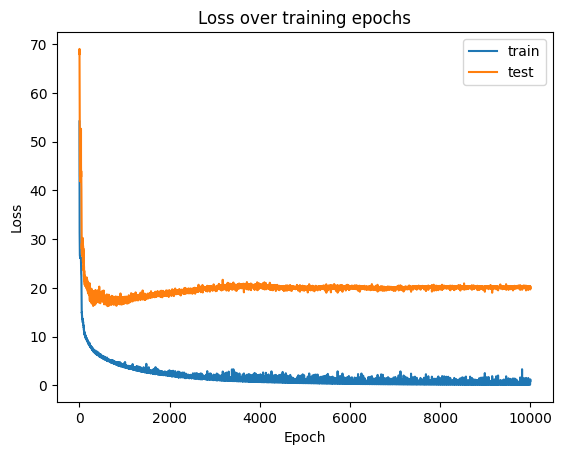

In [27]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

Our model converged quite well. Seems like we might've needed a larger validation set to smoothen the results, but that'll do for now.

### Saving the model

Let's store the model for later use:

In [22]:
# MODEL_PATH = 'model/Final_AE_10u_v1_norm.pth'
# torch.save(model.state_dict(), MODEL_PATH)

### Saving a history to file

In [23]:
# # save dictionary to person_data.pkl file
# with open('history/Final_AE_10u_v1_norm.pkl', 'wb') as fp:
#     pickle.dump(history, fp)
#     print('History dictionary saved successfully to file')

### Load Model

Uncomment the next lines, if you want to download and load the pre-trained model:

In [24]:
batch_size = BATCH_SIZE
seq_len = 96
n_features = 1

model = AE_LSTM(seq_len, n_features)

# Load the model state_dict
state_dict = torch.load('model/Final_AE_10u_v1_norm.pth')

# Load the state_dict into the model
model.load_state_dict(state_dict)
model = model.to(device)

### Load History

In [25]:
# Read dictionary pkl file
with open('history/Final_AE_10u_v1_norm.pkl', 'rb') as fp:
    history = pickle.load(fp)
    print('History dictionary')
    print(history.keys())

History dictionary
dict_keys(['train', 'val'])


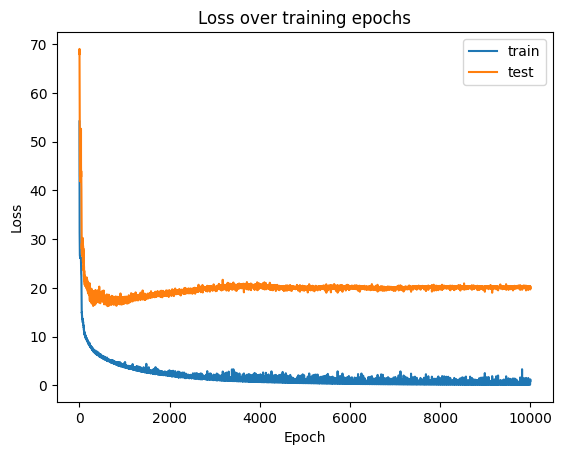

In [26]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

## Choosing a threshold

### Training Loss

In [27]:
def predict(model, dataset):
    predictions = []
    reconstruction_losses = []
    abs_errs = []
    criterion = nn.MSELoss(reduction='sum').to(device)
    
    with torch.no_grad():
        model = model.eval()
        for seq_true in dataset:
            seq_true = seq_true.to(device)
            seq_pred, encoded = model(seq_true)

            reconstruction_loss = criterion(seq_pred, seq_true)
            
            # abs_err = np.abs((seq_true.detach().cpu().numpy() - seq_pred.detach().cpu().numpy())/seq_pred.detach().cpu().numpy())
            abs_err = torch.abs((seq_true - seq_pred) / seq_pred)

            predictions.append(seq_pred.cpu().numpy().flatten())
            reconstruction_losses.append(reconstruction_loss.item())
            abs_errs.append(abs_err.sum().item())
            
    return predictions, reconstruction_losses, abs_errs

In [28]:
BATCH_SIZE = 1

# Prepare the data for the model using DataLoader with single batch size
train_dataloader_single = DataLoader(train_data_tensor, batch_size=BATCH_SIZE, shuffle=False)

val_dataloader_single = DataLoader(val_data_tensor, batch_size=BATCH_SIZE, shuffle=False)

test_dataloader_single = DataLoader(test_data_tensor, batch_size=BATCH_SIZE, shuffle=False)

In [29]:
# Train dataset
predictions_train, reconstruction_losses_train, abs_errs_train = predict(model, train_dataloader_single)

# Test dataset
predictions_test, reconstruction_losses_test, abs_errs_test = predict(model, test_dataloader_single)

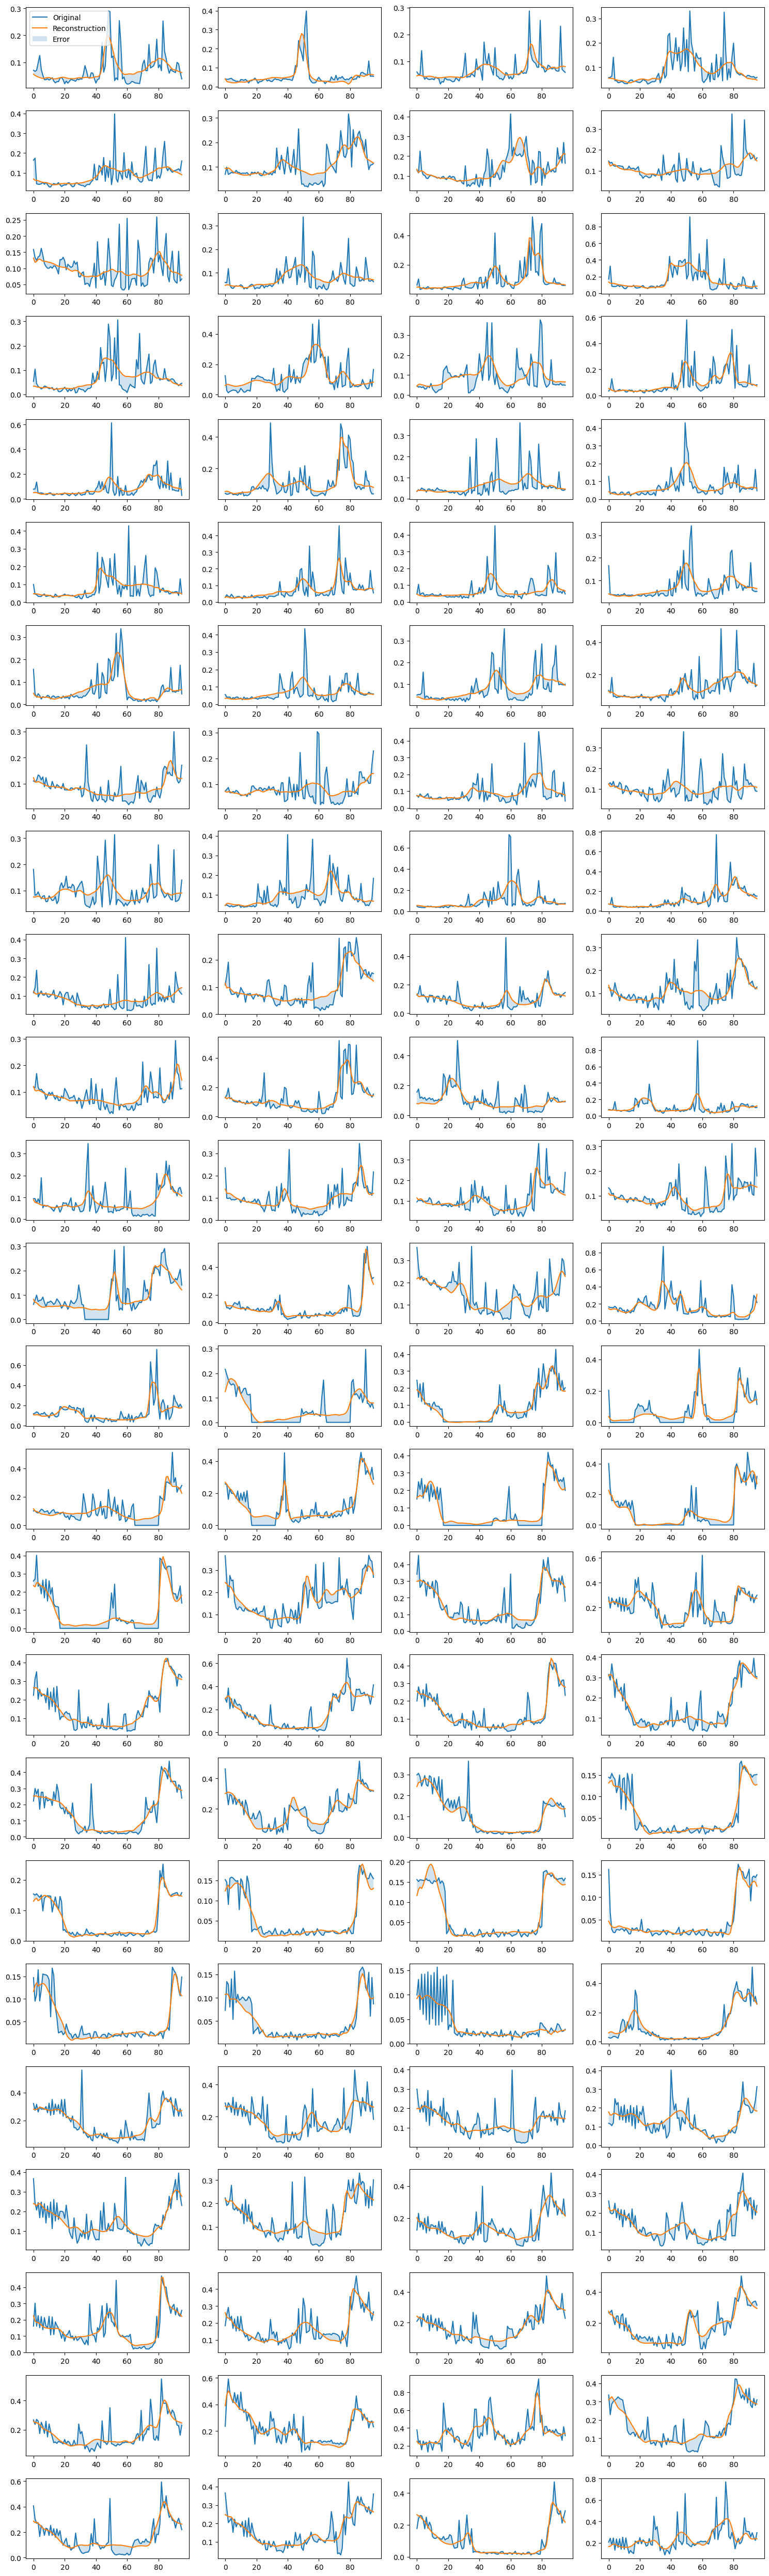

In [30]:
import math

num_plots = 100  # Set the number of plots you want to display

window_length = 96
columns = 4
rows = math.ceil(num_plots / columns)

fig, axes = plt.subplots(rows, columns, figsize=(15, 2 * rows))

for i in range(num_plots):
    row = i // columns
    col = i % columns
    ax = axes[row, col]
    
    x = train_data_tensor[i].cpu().numpy().flatten()
    x_pred = predictions_train[i].flatten()
    
    ax.plot(x, label='Original')
    ax.plot(x_pred, label='Reconstruction')
    ax.fill_between(np.arange(window_length), x, x_pred, alpha=0.2, label='Error')
    
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()


## Loss Histrogram

## Anomaly Score (Fixed-Threshold)

### Training Loss

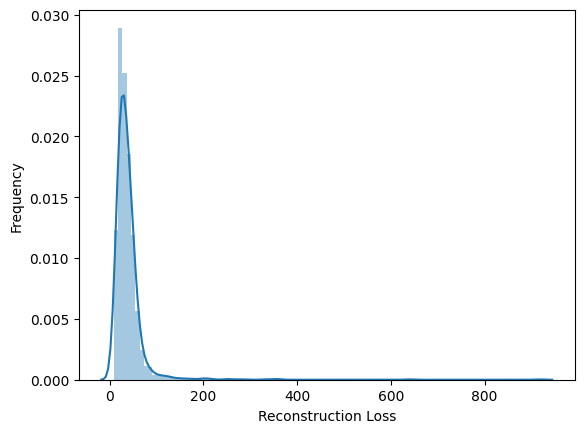

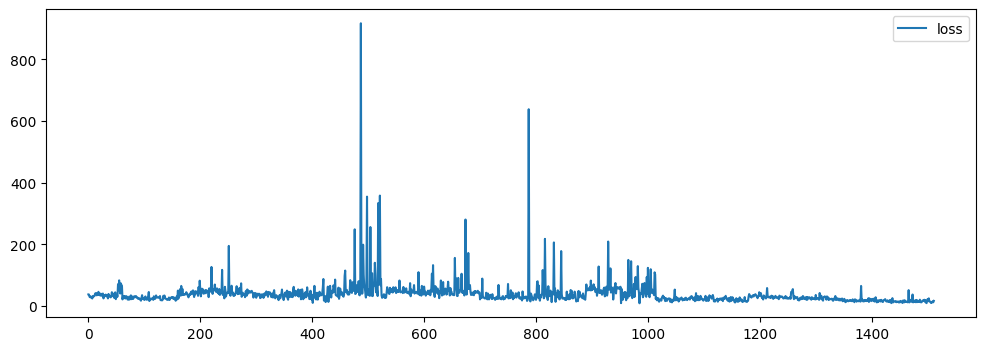

In [31]:
# Train dataset
# predictions_train, reconstruction_losses_train, _, abs_errs_train, _, _, _ = predict(model, train_dataloader_single)

# sns.distplot(reconstruction_losses_train, bins=100, kde=True)
sns.distplot(abs_errs_train, bins=100, kde=True)
plt.xlabel('Reconstruction Loss')
plt.ylabel('Frequency')
plt.show();

# Loss for each window of the train set vs Threshold
# reconstruction_losses_train_array = np.array(reconstruction_losses_train).flatten()
abs_errs_train_array = np.array(abs_errs_train).flatten()

plt.figure(figsize=(12,4))
plt.plot(abs_errs_train_array, label='loss')
plt.legend()
plt.show()

#### Selection Threshold

In [32]:
#this does not work because the reconstruction losses are right-skewed distribution not a normal distribution

# Standard Deviation Approach
#threshold = mean of the loss + C * standard devation of the loss
threshold_1std = np.mean(abs_errs_train) + 1 * np.std(abs_errs_train)
print(f'The anomaly score for 1 STD is {threshold_1std:.2f}')

threshold_3std = np.mean(abs_errs_train) + 2 * np.std(abs_errs_train)
print(f'The anomaly score for 3 STD is {threshold_3std:.2f}')

# Percentile-Based Approach
# https://pub.towardsai.net/autoencoder-for-anomaly-detection-using-tensorflow-keras-7fdfa9f3ad99
# Check the prediction loss threshold for 2% of outliers
threshold_percentile = np.percentile(abs_errs_train, 75)
print(f'The anomaly score for percentile is {threshold_percentile:.2f}')

# Interquartile Range (IQR) Approach
Q1 = np.percentile(abs_errs_train, 25)
Q3 = np.percentile(abs_errs_train, 75)
IQR = Q3 - Q1
threshold_iqr = Q3 + 1.5 * IQR
print(f'The anomaly score for IQR is {threshold_iqr:.2f}')

# Median Absolute Deviation Approach(MAD)
# https://aakinshin.net/posts/mad-caveats/
def mad(data):
    return np.median(np.abs(data - np.median(data)))

threshold_mad = np.median(abs_errs_train) + 1.4826 * mad(abs_errs_train)
print(f'The anomaly score for 1.4826 MADs is {threshold_mad:.2f}')

The anomaly score for 1 STD is 77.71
The anomaly score for 3 STD is 116.57
The anomaly score for percentile is 44.82
The anomaly score for IQR is 76.36
The anomaly score for 1.4826 MADs is 47.36


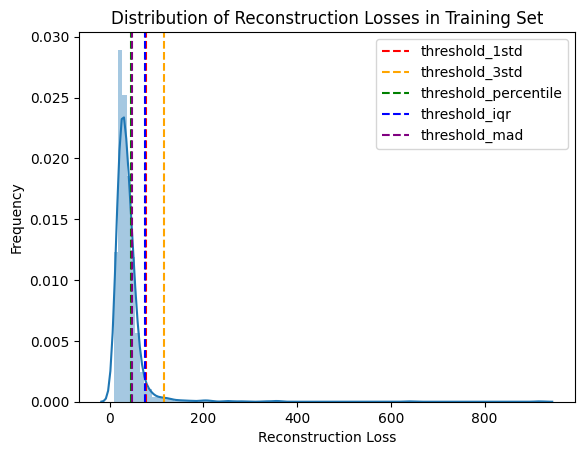

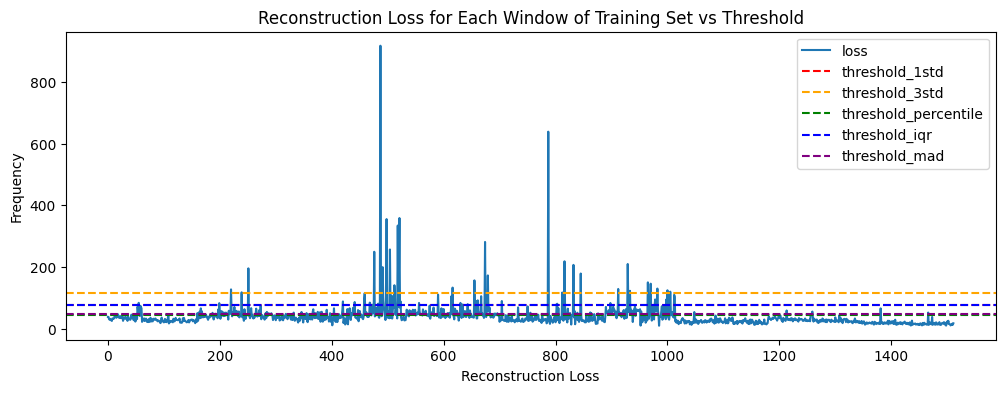

In [33]:
# Plotting the distribution of the reconstruction losses in the training set
sns.distplot(abs_errs_train, bins=100, kde=True)
plt.axvline(threshold_1std, color='red', linestyle='dashed', label='threshold_1std')
plt.axvline(threshold_3std, color='orange', linestyle='dashed', label='threshold_3std')
plt.axvline(threshold_percentile, color='green', linestyle='dashed', label='threshold_percentile')
plt.axvline(threshold_iqr, color='blue', linestyle='dashed', label='threshold_iqr')
plt.axvline(threshold_mad, color='purple', linestyle='dashed', label='threshold_mad')
plt.xlabel('Reconstruction Loss')
plt.ylabel('Frequency')
plt.title('Distribution of Reconstruction Losses in Training Set')
plt.legend()
plt.show()

# Loss for each window of the train set vs Threshold
abs_errs_train_array = np.array(abs_errs_train).flatten()

plt.figure(figsize=(12,4))
plt.plot(abs_errs_train_array, label='loss')
plt.axhline(threshold_1std, color='red', linestyle='dashed', label='threshold_1std')
plt.axhline(threshold_3std, color='orange', linestyle='dashed', label='threshold_3std')
plt.axhline(threshold_percentile, color='green', linestyle='dashed', label='threshold_percentile')
plt.axhline(threshold_iqr, color='blue', linestyle='dashed', label='threshold_iqr')
plt.axhline(threshold_mad, color='purple', linestyle='dashed', label='threshold_mad')
plt.title('Reconstruction Loss for Each Window of Training Set vs Threshold')
plt.xlabel('Reconstruction Loss')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [34]:
# Anomaly Score -> Standard Deviation Approach
correct = sum(l <= threshold_1std for l in abs_errs_train)
print(f'Correct normal predictions: {correct}/{len(train_dataloader_single)}, ({round((correct*100/len(train_dataloader_single)),2)}%)')
correct = sum(l <= threshold_3std for l in abs_errs_train)
print(f'Correct normal predictions: {correct}/{len(train_dataloader_single)}, ({round((correct*100/len(train_dataloader_single)),2)}%)')

# Anomaly Score -> Percentile-Based Approach
correct = sum(l <= threshold_percentile for l in abs_errs_train)
print(f'Correct normal predictions: {correct}/{len(train_dataloader_single)}, ({round((correct*100/len(train_dataloader_single)),2)}%)')

# Anomaly Score -> Interquartile Range (IQR) Approach
correct = sum(l <= threshold_iqr for l in abs_errs_train)
print(f'Correct normal predictions: {correct}/{len(train_dataloader_single)}, ({round((correct*100/len(train_dataloader_single)),2)}%)')

# Anomaly Score -> Median Absolute Deviation Approach(MAD)
correct = sum(l <= threshold_mad for l in abs_errs_train)
print(f'Correct normal predictions: {correct}/{len(train_dataloader_single)}, ({round((correct*100/len(train_dataloader_single)),2)}%)')

Correct normal predictions: 1448/1512, (95.77%)
Correct normal predictions: 1483/1512, (98.08%)
Correct normal predictions: 1134/1512, (75.0%)
Correct normal predictions: 1447/1512, (95.7%)
Correct normal predictions: 1219/1512, (80.62%)


### Testing Loss

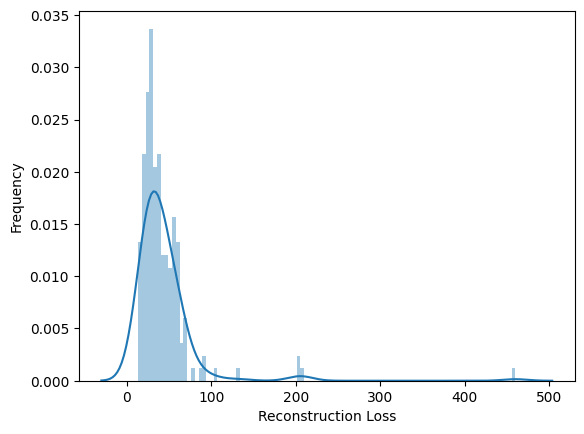

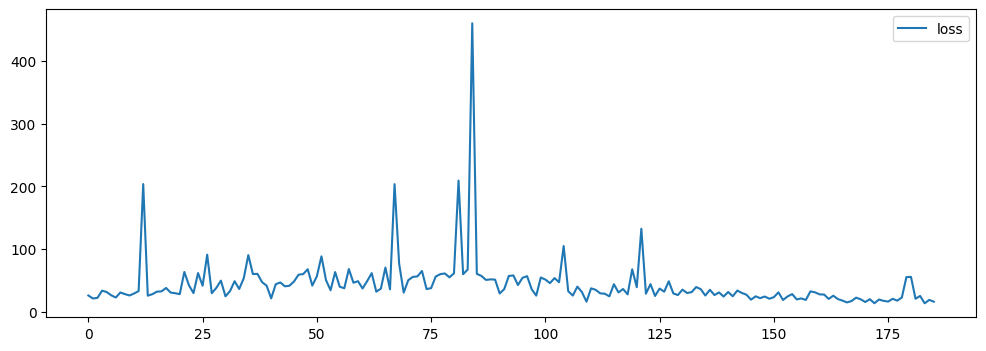

In [35]:
# Test dataset
# predictions_test, reconstruction_losses_test, _, abs_errs_test, encoded_test, mean_test, std_test = predict(model, test_dataloader_single)

sns.distplot(abs_errs_test, bins=100, kde=True)
plt.xlabel('Reconstruction Loss')
plt.ylabel('Frequency')
plt.show();

# Loss for each window of the test set vs Threshold
abs_errs_test_array = np.array(abs_errs_test).flatten()

plt.figure(figsize=(12,4))
plt.plot(abs_errs_test_array, label='loss')
plt.legend()
plt.show()

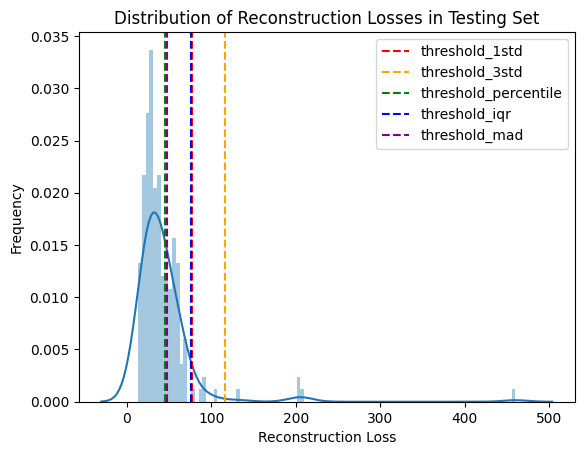

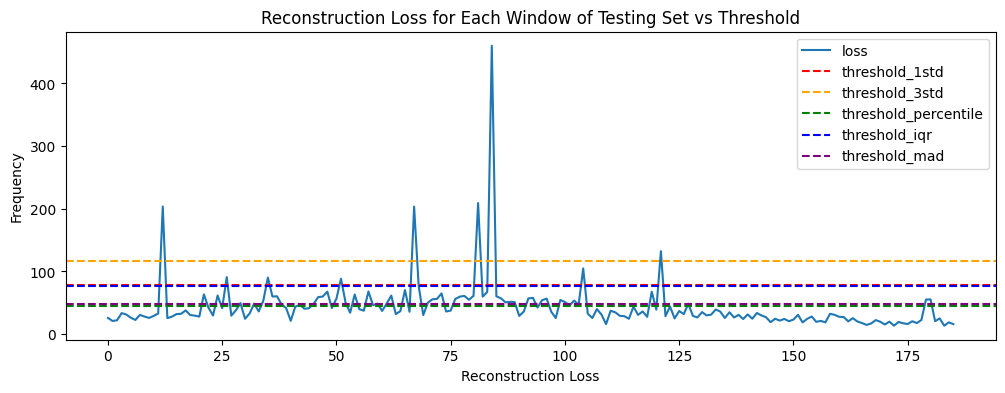

In [36]:
abs_errs = abs_errs_test

# Plotting the distribution of the reconstruction losses in the training set
sns.distplot(abs_errs, bins=100, kde=True)
plt.axvline(threshold_1std, color='red', linestyle='dashed', label='threshold_1std')
plt.axvline(threshold_3std, color='orange', linestyle='dashed', label='threshold_3std')
plt.axvline(threshold_percentile, color='green', linestyle='dashed', label='threshold_percentile')
plt.axvline(threshold_iqr, color='blue', linestyle='dashed', label='threshold_iqr')
plt.axvline(threshold_mad, color='purple', linestyle='dashed', label='threshold_mad')
plt.xlabel('Reconstruction Loss')
plt.ylabel('Frequency')
plt.title('Distribution of Reconstruction Losses in Testing Set')
plt.legend()
plt.show()

# Loss for each window of the train set vs Threshold
abs_errs_array = np.array(abs_errs).flatten()

plt.figure(figsize=(12,4))
plt.plot(abs_errs_array, label='loss')
plt.axhline(threshold_1std, color='red', linestyle='dashed', label='threshold_1std')
plt.axhline(threshold_3std, color='orange', linestyle='dashed', label='threshold_3std')
plt.axhline(threshold_percentile, color='green', linestyle='dashed', label='threshold_percentile')
plt.axhline(threshold_iqr, color='blue', linestyle='dashed', label='threshold_iqr')
plt.axhline(threshold_mad, color='purple', linestyle='dashed', label='threshold_mad')
plt.title('Reconstruction Loss for Each Window of Testing Set vs Threshold')
plt.xlabel('Reconstruction Loss')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [37]:
rec_loss = abs_errs_test
window_len = test_dataloader_single

# Anomaly Score -> Standard Deviation Approach
correct = sum(l <= threshold_1std for l in rec_loss)
print(f'Correct normal predictions: {correct}/{len(window_len)}, ({round((correct*100/len(window_len)),2)}%)')
correct = sum(l <= threshold_3std for l in rec_loss)
print(f'Correct normal predictions: {correct}/{len(window_len)}, ({round((correct*100/len(window_len)),2)}%)')

# Anomaly Score -> Percentile-Based Approach
correct = sum(l <= threshold_percentile for l in rec_loss)
print(f'Correct normal predictions: {correct}/{len(window_len)}, ({round((correct*100/len(window_len)),2)}%)')

# Anomaly Score -> Interquartile Range (IQR) Approach
correct = sum(l <= threshold_iqr for l in rec_loss)
print(f'Correct normal predictions: {correct}/{len(window_len)}, ({round((correct*100/len(window_len)),2)}%)')

# Anomaly Score -> Median Absolute Deviation Approach(MAD)
correct = sum(l <= threshold_mad for l in rec_loss)
print(f'Correct normal predictions: {correct}/{len(window_len)}, ({round((correct*100/len(window_len)),2)}%)')

Correct normal predictions: 177/186, (95.16%)
Correct normal predictions: 181/186, (97.31%)
Correct normal predictions: 125/186, (67.2%)
Correct normal predictions: 176/186, (94.62%)
Correct normal predictions: 130/186, (69.89%)


## Evaluation

### Data for Testing

In [38]:
users_for_test = pd.read_csv('datasets/datafortesting/user_for_test.csv')
users_for_test = users_for_test.sort_values('user')
print(users_for_test['user'].unique())
users_for_test

[  22   50   80   85  101  119  139  183  287  292  357  359  362  395
  396  418  419  438  439  446  452  492  493  497  517  528  530  643
  687  775  776  850  852  855  859  885  911  952  954 1014 1077 1088
 1115 1155 1157 1158 1160 1195 1283 1345 1349 1350 1351 1418 1427 1440
 1463 1472 1476 1497 1501 1506 1539 1582 1591 1639 1643 1664 1695 1697
 1708 1727 1728 1736 1746 1756 1840 1858 1883 1889 1896 1918 1943 1949
 1959 1960 1962 1971]


MeterID            DATE-Time    KWH  user
0        6200063350  2021-01-01 00:00:00  0.168    22
15226    6200063350  2021-06-13 18:30:00  0.096    22
15225    6200063350  2021-06-13 18:15:00  0.130    22
15224    6200063350  2021-06-13 18:00:00  0.141    22
15223    6200063350  2021-06-13 17:45:00  0.145    22
...             ...                  ...    ...   ...
1757674  6200046515  2021-03-11 20:15:00  0.113  1971
1757673  6200046515  2021-03-11 20:00:00  1.254  1971
1757672  6200046515  2021-03-11 19:45:00  1.028  1971
1757679  6200046515  2021-03-11 21:30:00  0.575  1971
1770808  6200046515  2021-07-31 23:45:00  0.611  1971

[1770809 rows x 4 columns]

In [39]:
def clean_data(df, user_id):
    # Select the data for the specified user
    user_data = df[df['user']==int(user_id)]

    # Drop not useful columns
    user_data['DATE-Time'] = pd.to_datetime(user_data['DATE-Time'], infer_datetime_format=True)
    user_data.drop(columns=["MeterID", "user"], inplace=True)

    # Resample `15min` in order to have completed `"DATE-Time"`
    # I have `'DATE-Time'` 32760 rows (32760/96=341.25 Days)
    # It should be (365day * 96point = 35040 rows)
    # I have to reset index in order to hava 35040 rows
    # Fill the missing value
    user_data = user_data.set_index('DATE-Time').resample("15T").mean()
    
    # Convert the index to a DatetimeIndex object
    user_data.index = pd.to_datetime(user_data.index)

    # Count the number of zero values in each day
    zero_counts = user_data.groupby(user_data.index.floor('D'))['KWH'].apply(lambda x: (x == 0).sum())

    # Get the dates where the number of zero values is less than or equal to 48
    valid_dates = zero_counts[zero_counts <= 48].index

    # Drop the dates where the number of zero values is greater than 48
    user_data = user_data[user_data.index.floor('D').isin(valid_dates)]

    # Drop the days that have NaN values
    # Check which rows have at least one missing value
    missing_days = user_data.isnull().any(axis=1)

    # Get the dates (i.e., indices) of the rows that have missing values
    missing_days_index = missing_days[missing_days].index

    # Get the unique dates that have missing values
    missing_dates = pd.Series(missing_days_index.date).unique().tolist()

    # Drop the entire dates that contain Nan values
    user_data_clean = user_data[~user_data.index.to_series().dt.date.isin(missing_dates)]
    
    if user_data_clean.empty:
        return None

    return user_data_clean

In [40]:
user_1 = clean_data(users_for_test, 22)
user_1

KWH
DATE-Time                 
2021-01-01 00:00:00  0.168
2021-01-01 00:15:00  0.140
2021-01-01 00:30:00  0.126
2021-01-01 00:45:00  0.115
2021-01-01 01:00:00  0.115
...                    ...
2021-08-31 22:45:00  0.145
2021-08-31 23:00:00  0.158
2021-08-31 23:15:00  0.617
2021-08-31 23:30:00  0.544
2021-08-31 23:45:00  0.436

[21120 rows x 1 columns]

In [41]:
def create_windowed_dataset(data, window_size):
    # Calculate the number of windows that fit in the data
    num_windows = len(data) // window_size
    
    # Truncate data to fit into windowed data exactly
    data = data[:num_windows*window_size]
    
    # Reshape the data into a 3D tensor of (num_windows, window_size, num_features)
    # Here we're adding an extra dimension to the data to represent the features, which is 1 in our case
    windowed_data = np.reshape(data, (num_windows, window_size, 1))
    
    return windowed_data

def normalize_and_create_windowed_test_data(data, window_size=96, RANDOM_SEED=42):
    # Initialize a MinMaxScaler object
    scaler = MinMaxScaler()

    # Fit the scaler to the data and transform it
    data_normalized = scaler.fit_transform(data)

    # Create windowed datasets
    data_windowed = create_windowed_dataset(data_normalized, window_size)

    return data_windowed, scaler

In [42]:
test_data_windowed, scaler = normalize_and_create_windowed_test_data(user_1)
print(f"Test data shape: {test_data_windowed.shape}")

Test data shape: (220, 96, 1)


In [43]:
# Convert the windowed test data to PyTorch tensors
test_data_tensor = torch.tensor(test_data_windowed).float()

# Create a DataLoader for the test data
test_dataloader = DataLoader(test_data_tensor, batch_size=1, shuffle=False)

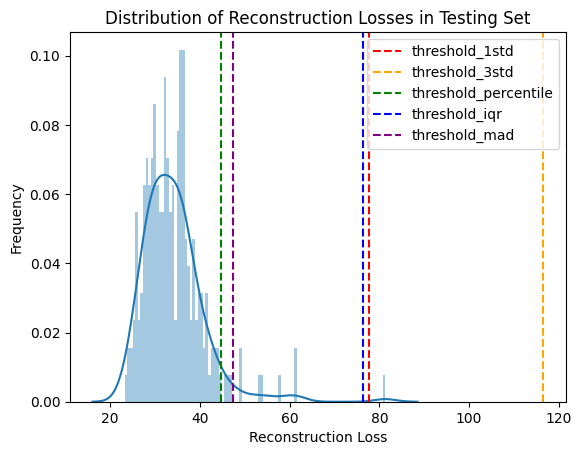

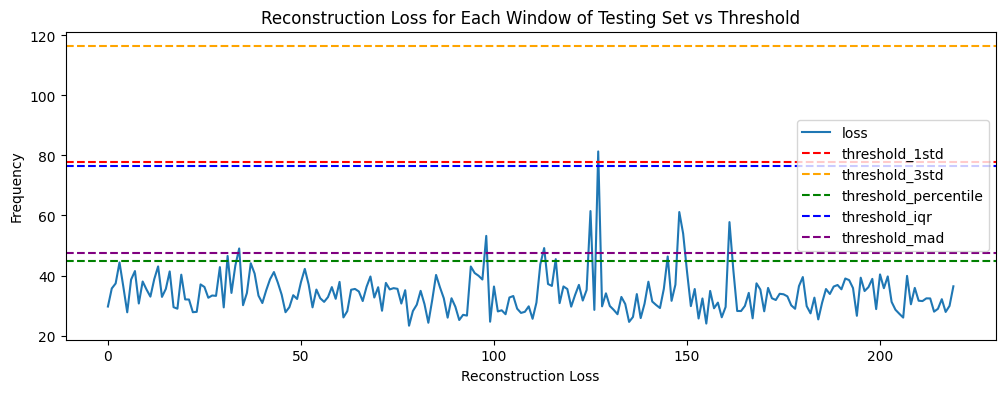

In [44]:
# Test new dataset
pred_test, rec_test, abs_errs = predict(model, test_dataloader)

abs_errs = abs_errs

# Plotting the distribution of the reconstruction losses in the training set
sns.distplot(abs_errs, bins=100, kde=True)
plt.axvline(threshold_1std, color='red', linestyle='dashed', label='threshold_1std')
plt.axvline(threshold_3std, color='orange', linestyle='dashed', label='threshold_3std')
plt.axvline(threshold_percentile, color='green', linestyle='dashed', label='threshold_percentile')
plt.axvline(threshold_iqr, color='blue', linestyle='dashed', label='threshold_iqr')
plt.axvline(threshold_mad, color='purple', linestyle='dashed', label='threshold_mad')
plt.xlabel('Reconstruction Loss')
plt.ylabel('Frequency')
plt.title('Distribution of Reconstruction Losses in Testing Set')
plt.legend()
plt.show()

# Loss for each window of the train set vs Threshold
abs_errs_array = np.array(abs_errs).flatten()

plt.figure(figsize=(12,4))
plt.plot(abs_errs_array, label='loss')
plt.axhline(threshold_1std, color='red', linestyle='dashed', label='threshold_1std')
plt.axhline(threshold_3std, color='orange', linestyle='dashed', label='threshold_3std')
plt.axhline(threshold_percentile, color='green', linestyle='dashed', label='threshold_percentile')
plt.axhline(threshold_iqr, color='blue', linestyle='dashed', label='threshold_iqr')
plt.axhline(threshold_mad, color='purple', linestyle='dashed', label='threshold_mad')
plt.title('Reconstruction Loss for Each Window of Testing Set vs Threshold')
plt.xlabel('Reconstruction Loss')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [45]:
rec_loss = abs_errs
window_len = test_dataloader

# Anomaly Score -> Standard Deviation Approach
correct = sum(l <= threshold_1std for l in rec_loss)
print(f'Correct normal predictions: {correct}/{len(window_len)}, ({round((correct*100/len(window_len)),2)}%)')
correct = sum(l <= threshold_3std for l in rec_loss)
print(f'Correct normal predictions: {correct}/{len(window_len)}, ({round((correct*100/len(window_len)),2)}%)')

# Anomaly Score -> Percentile-Based Approach
correct = sum(l <= threshold_percentile for l in rec_loss)
print(f'Correct normal predictions: {correct}/{len(window_len)}, ({round((correct*100/len(window_len)),2)}%)')

# Anomaly Score -> Interquartile Range (IQR) Approach
correct = sum(l <= threshold_iqr for l in rec_loss)
print(f'Correct normal predictions: {correct}/{len(window_len)}, ({round((correct*100/len(window_len)),2)}%)')

# Anomaly Score -> Median Absolute Deviation Approach(MAD)
correct = sum(l <= threshold_mad for l in rec_loss)
print(f'Correct normal predictions: {correct}/{len(window_len)}, ({round((correct*100/len(window_len)),2)}%)')

Correct normal predictions: 219/220, (99.55%)
Correct normal predictions: 220/220, (100.0%)
Correct normal predictions: 209/220, (95.0%)
Correct normal predictions: 219/220, (99.55%)
Correct normal predictions: 212/220, (96.36%)


# Anomalies

## Generate Artificial Samples

In [46]:
# Generate artificial samples for attack type 1: Consumption profile modification
def generate_attack_type_1(data):
    np.random.seed(42)
    data_copy = data.copy()
    alpha = np.random.uniform(0.2, 0.8)
    return data_copy * alpha

# Generate artificial samples for attack type 2: Meter data modification
def generate_attack_type_2(data):
    np.random.seed(42)
    data_copy = data.copy()
    gamma = np.random.uniform(0.2, 0.8, size=data_copy.shape[0])
    return data_copy * gamma.reshape(-1, 1)


# Generate artificial samples for attack type 3: Meter tampering detection evasion
def generate_attack_type_3(data):
    np.random.seed(42)
    start_time = np.random.randint(0, 96 - 24)
    duration = np.random.randint(24, 96)
    end_time = start_time + duration
    attack = data.copy()
    attack[start_time:end_time] = 0
    return attack

# Generate artificial samples for attack type 4: Magnetic field detection evasion
def generate_attack_type_4(data):
    np.random.seed(42)
    data_copy = data.copy()
    mean_value = np.mean(data_copy)
    mean_value = np.full(data_copy.shape, mean_value)
    gamma = np.random.uniform(0.2, 0.8, size=data_copy.shape[0])
    return gamma.reshape(-1, 1) * mean_value

# Generate artificial samples for attack type 5: Jamming attack
def generate_attack_type_5(data):
    np.random.seed(42)
    data_copy = data.copy()
    mean_value = np.mean(data_copy)
    return np.full(data_copy.shape, mean_value)

# Generate artificial samples for attack type 6: False data injection
def generate_attack_type_6(data):
    np.random.seed(42)
    data_copy = data.copy()
    inverted_data = data_copy[::-1]
    return inverted_data

### Generate Attack type 1

In [47]:
# For attack type 1
attack_1_windows = []

for window in test_data_windowed:
    attack_window = generate_attack_type_1(window)
    attack_window = scaler.transform(attack_window.reshape(-1, 1))
    attack_1_windows.append(attack_window)
    
# Convert the list of windows to a numpy array and then to a PyTorch tensor
attack_1_windows = np.array(attack_1_windows)
attack_1_tensor = torch.Tensor(attack_1_windows)

# Make a DataLoader for each attack type
attack_1_dataloader = DataLoader(attack_1_tensor, batch_size=1, shuffle=False)

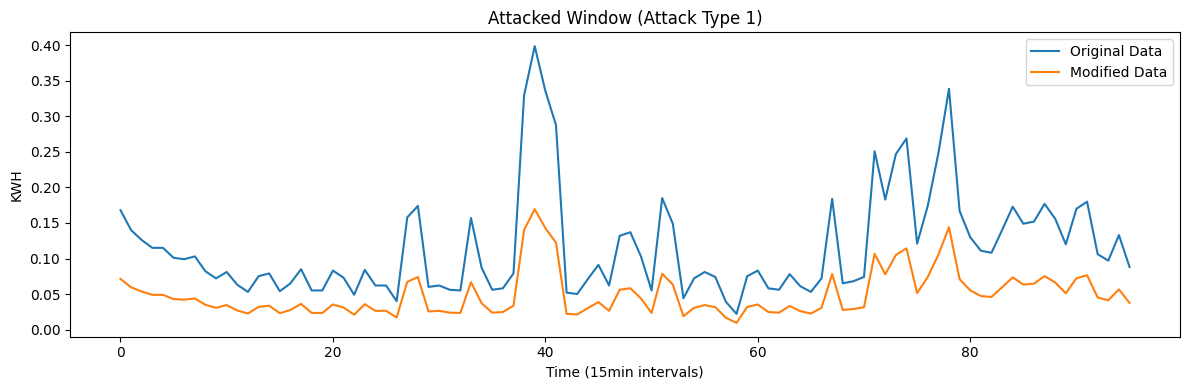

In [48]:
# Select a window
window_index = 0
original_window = test_data_windowed[window_index]

# Apply the attack
attacked_window = generate_attack_type_1(original_window)

# Invert the scaling
original_window_rescaled = scaler.inverse_transform(original_window)
attacked_window_rescaled = scaler.inverse_transform(attacked_window)

# Plot the original and attacked window
plt.figure(figsize=(12, 4))

# Plot the original window
plt.plot(original_window_rescaled)
plt.plot(attacked_window_rescaled)
plt.title('Attacked Window (Attack Type 1)')
plt.xlabel('Time (15min intervals)')
plt.ylabel('KWH')
plt.legend(["Original Data", "Modified Data"])
plt.tight_layout()
plt.show();

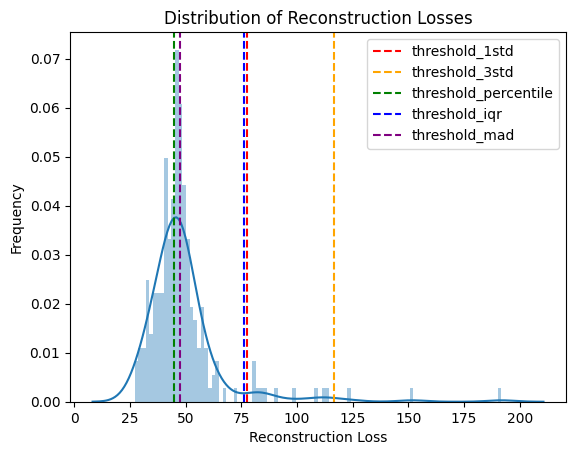

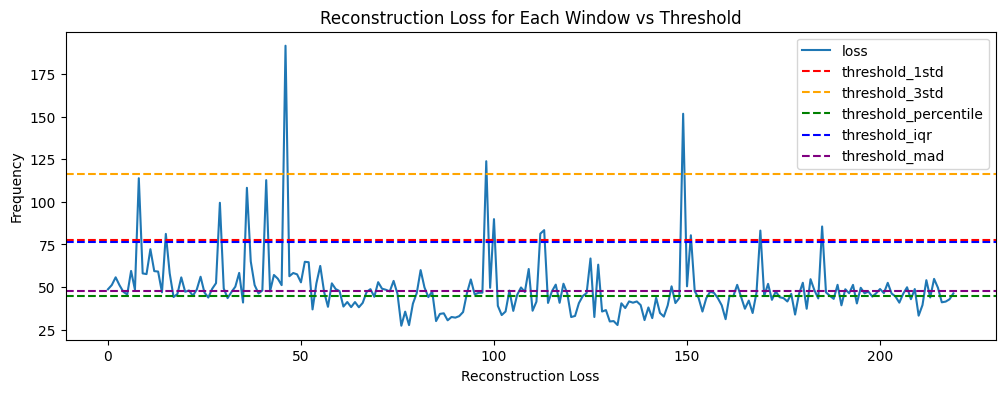

In [49]:
# Get the reconstruction errors for each attack type.
_, rec_error_1, abs_errs_1 = predict(model, attack_1_dataloader)

abs_errs = abs_errs_1

# Plotting the distribution of the reconstruction losses in the training set
sns.distplot(abs_errs, bins=100, kde=True)
plt.axvline(threshold_1std, color='red', linestyle='dashed', label='threshold_1std')
plt.axvline(threshold_3std, color='orange', linestyle='dashed', label='threshold_3std')
plt.axvline(threshold_percentile, color='green', linestyle='dashed', label='threshold_percentile')
plt.axvline(threshold_iqr, color='blue', linestyle='dashed', label='threshold_iqr')
plt.axvline(threshold_mad, color='purple', linestyle='dashed', label='threshold_mad')
plt.xlabel('Reconstruction Loss')
plt.ylabel('Frequency')
plt.title('Distribution of Reconstruction Losses')
plt.legend()
plt.show()

# Loss for each window of the train set vs Threshold
abs_errs_array = np.array(abs_errs).flatten()

plt.figure(figsize=(12,4))
plt.plot(abs_errs_array, label='loss')
plt.axhline(threshold_1std, color='red', linestyle='dashed', label='threshold_1std')
plt.axhline(threshold_3std, color='orange', linestyle='dashed', label='threshold_3std')
plt.axhline(threshold_percentile, color='green', linestyle='dashed', label='threshold_percentile')
plt.axhline(threshold_iqr, color='blue', linestyle='dashed', label='threshold_iqr')
plt.axhline(threshold_mad, color='purple', linestyle='dashed', label='threshold_mad')
plt.title('Reconstruction Loss for Each Window vs Threshold')
plt.xlabel('Reconstruction Loss')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [50]:
rec_loss = abs_errs_1
window_len = attack_1_dataloader

# Anomaly Score -> Standard Deviation Approach
correct = sum(l >= threshold_1std for l in rec_loss)
print(f'Predicted anomalies (1STD): {correct}/{len(window_len)}, ({round((correct*100/len(window_len)),2)}%)')
correct = sum(l >= threshold_3std for l in rec_loss)
print(f'Predicted anomalies (3STD): {correct}/{len(window_len)}, ({round((correct*100/len(window_len)),2)}%)')

# Anomaly Score -> Percentile-Based Approach
correct = sum(l >= threshold_percentile for l in rec_loss)
print(f'Predicted anomalies (Percentile): {correct}/{len(window_len)}, ({round((correct*100/len(window_len)),2)}%)')

# Anomaly Score -> Interquartile Range (IQR) Approach
correct = sum(l >= threshold_iqr for l in rec_loss)
print(f'Predicted anomalies (IQR): {correct}/{len(window_len)}, ({round((correct*100/len(window_len)),2)}%)')

# Anomaly Score -> Median Absolute Deviation Approach(MAD)
correct = sum(l >= threshold_mad for l in rec_loss)
print(f'Predicted anomalies (MAD): {correct}/{len(window_len)}, ({round((correct*100/len(window_len)),2)}%)')

Predicted anomalies (1STD): 14/220, (6.36%)
Predicted anomalies (3STD): 3/220, (1.36%)
Predicted anomalies (Percentile): 127/220, (57.73%)
Predicted anomalies (IQR): 14/220, (6.36%)
Predicted anomalies (MAD): 91/220, (41.36%)


In [51]:
# Generate true labels
true_labels = [1] * len(window_len)   # 1 represents an anomaly

thresholds = [threshold_1std, threshold_3std, threshold_percentile, threshold_iqr, threshold_mad]
labels = ['1STD', '3STD', 'Percentile', 'IQR', 'MAD']

# Iterate over each threshold and label
for threshold, label in zip(thresholds, labels):
    # Generate predicted labels for the current threshold
    predicted_labels = [int(l >= threshold) for l in rec_loss]

    # Compute precision, recall, and F1 score
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)

    # Print the results
    print(f"For {label} threshold:")
    print(f"Precision: {round((precision),2)}")
    print(f"Recall: {round((recall),2)}")
    print(f"F1 score: {round((f1),2)}")
    print()

For 1STD threshold:
Precision: 1.0
Recall: 0.06
F1 score: 0.12

For 3STD threshold:
Precision: 1.0
Recall: 0.01
F1 score: 0.03

For Percentile threshold:
Precision: 1.0
Recall: 0.58
F1 score: 0.73

For IQR threshold:
Precision: 1.0
Recall: 0.06
F1 score: 0.12

For MAD threshold:
Precision: 1.0
Recall: 0.41
F1 score: 0.59



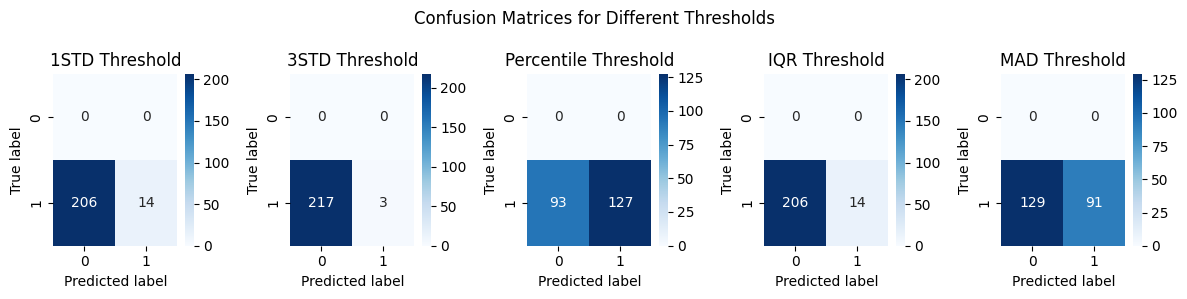

In [52]:
# Create subplots
fig, axs = plt.subplots(1, 5, figsize=(12, 3))

# Iterate over each threshold and label
for i, (threshold, label) in enumerate(zip(thresholds, labels)):
    # Generate predicted labels for the current threshold
    predicted_labels = [int(l >= threshold) for l in rec_loss]

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Plot confusion matrix in the corresponding subplot
    ax = axs[i]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_title(f'{label} Threshold')

# Set the title for the entire figure
fig.suptitle('Confusion Matrices for Different Thresholds')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

### Generate Attack type 2

In [53]:
# For attack type 2
attack_2_windows = []

for window in test_data_windowed:
    attack_window = generate_attack_type_2(window)
    attack_window = scaler.transform(attack_window.reshape(-1, 1))
    attack_2_windows.append(attack_window)
    
# Convert the list of windows to a numpy array and then to a PyTorch tensor
attack_2_windows = np.array(attack_2_windows)
print(attack_2_windows.shape)
attack_2_tensor = torch.Tensor(attack_2_windows)
print(attack_2_tensor.shape)

# Make a DataLoader for each attack type
attack_2_dataloader = DataLoader(attack_2_tensor, batch_size=1, shuffle=False)

(220, 96, 1)
torch.Size([220, 96, 1])


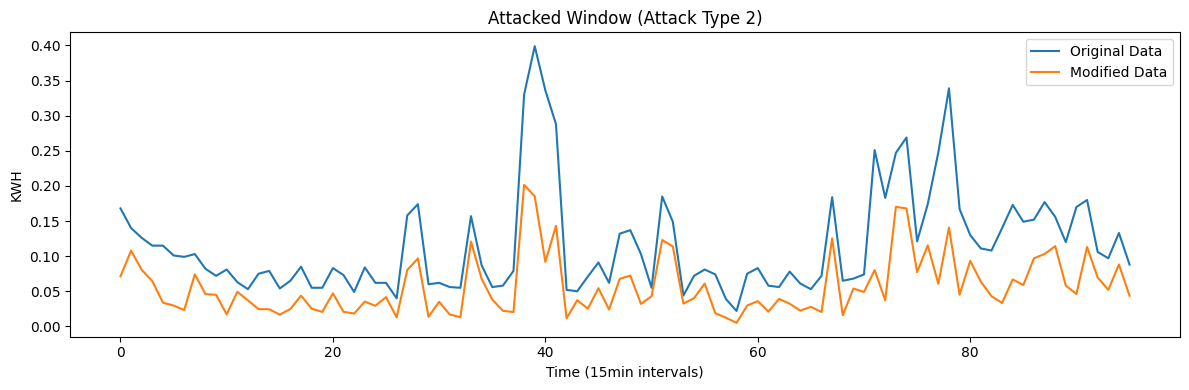

In [54]:
# Select a window
window_index = 0
original_window = test_data_windowed[window_index]

# Apply the attack
attacked_window = generate_attack_type_2(original_window)

# Invert the scaling
original_window_rescaled = scaler.inverse_transform(original_window)
attacked_window_rescaled = scaler.inverse_transform(attacked_window)

# Plot the original and attacked window
plt.figure(figsize=(12, 4))

# Plot the original window
plt.plot(original_window_rescaled)
plt.plot(attacked_window_rescaled)
plt.title('Attacked Window (Attack Type 2)')
plt.xlabel('Time (15min intervals)')
plt.ylabel('KWH')
plt.legend(["Original Data", "Modified Data"])
plt.tight_layout()
plt.show();

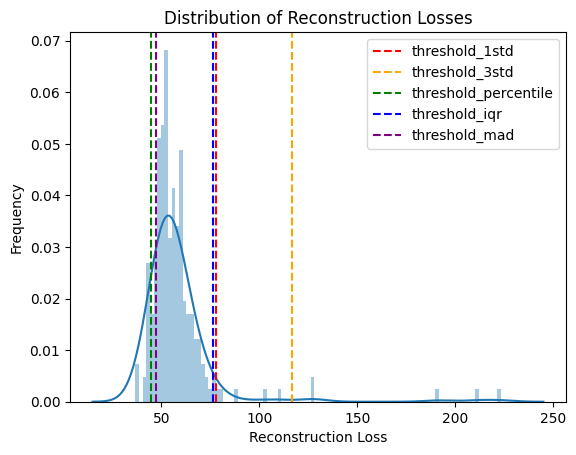

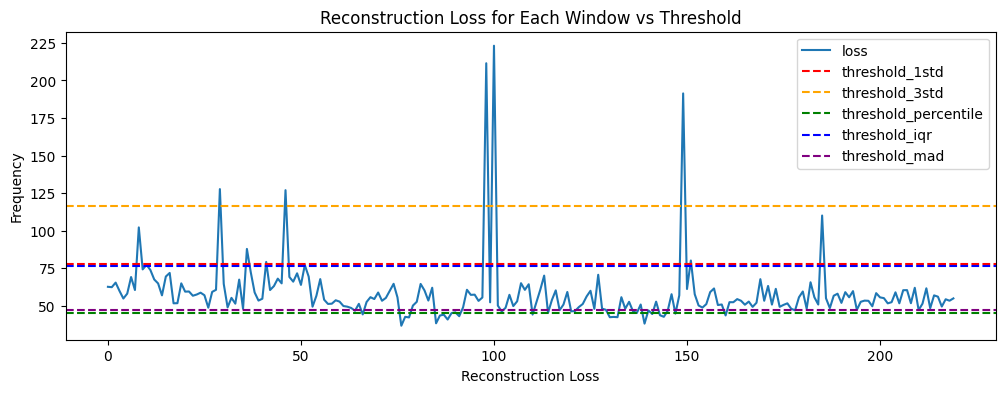

In [55]:
# Get the reconstruction errors for each attack type.
_, rec_error_2, abs_errs_2 = predict(model, attack_2_dataloader)

abs_errs = abs_errs_2

# Plotting the distribution of the reconstruction losses in the training set
sns.distplot(abs_errs, bins=100, kde=True)
plt.axvline(threshold_1std, color='red', linestyle='dashed', label='threshold_1std')
plt.axvline(threshold_3std, color='orange', linestyle='dashed', label='threshold_3std')
plt.axvline(threshold_percentile, color='green', linestyle='dashed', label='threshold_percentile')
plt.axvline(threshold_iqr, color='blue', linestyle='dashed', label='threshold_iqr')
plt.axvline(threshold_mad, color='purple', linestyle='dashed', label='threshold_mad')
plt.xlabel('Reconstruction Loss')
plt.ylabel('Frequency')
plt.title('Distribution of Reconstruction Losses')
plt.legend()
plt.show()

# Loss for each window of the train set vs Threshold
abs_errs_array = np.array(abs_errs).flatten()

plt.figure(figsize=(12,4))
plt.plot(abs_errs_array, label='loss')
plt.axhline(threshold_1std, color='red', linestyle='dashed', label='threshold_1std')
plt.axhline(threshold_3std, color='orange', linestyle='dashed', label='threshold_3std')
plt.axhline(threshold_percentile, color='green', linestyle='dashed', label='threshold_percentile')
plt.axhline(threshold_iqr, color='blue', linestyle='dashed', label='threshold_iqr')
plt.axhline(threshold_mad, color='purple', linestyle='dashed', label='threshold_mad')
plt.title('Reconstruction Loss for Each Window vs Threshold')
plt.xlabel('Reconstruction Loss')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [56]:
rec_loss = abs_errs_2
window_len = attack_1_dataloader

# Anomaly Score -> Standard Deviation Approach
correct = sum(l >= threshold_1std for l in rec_loss)
print(f'Predicted anomalies (1STD): {correct}/{len(window_len)}, ({round((correct*100/len(window_len)),2)}%)')
correct = sum(l >= threshold_3std for l in rec_loss)
print(f'Predicted anomalies (3STD): {correct}/{len(window_len)}, ({round((correct*100/len(window_len)),2)}%)')

# Anomaly Score -> Percentile-Based Approach
correct = sum(l >= threshold_percentile for l in rec_loss)
print(f'Predicted anomalies (Percentile): {correct}/{len(window_len)}, ({round((correct*100/len(window_len)),2)}%)')

# Anomaly Score -> Interquartile Range (IQR) Approach
correct = sum(l >= threshold_iqr for l in rec_loss)
print(f'Predicted anomalies (IQR): {correct}/{len(window_len)}, ({round((correct*100/len(window_len)),2)}%)')

# Anomaly Score -> Median Absolute Deviation Approach(MAD)
correct = sum(l >= threshold_mad for l in rec_loss)
print(f'Predicted anomalies (MAD): {correct}/{len(window_len)}, ({round((correct*100/len(window_len)),2)}%)')

Predicted anomalies (1STD): 10/220, (4.55%)
Predicted anomalies (3STD): 5/220, (2.27%)
Predicted anomalies (Percentile): 201/220, (91.36%)
Predicted anomalies (IQR): 12/220, (5.45%)
Predicted anomalies (MAD): 185/220, (84.09%)


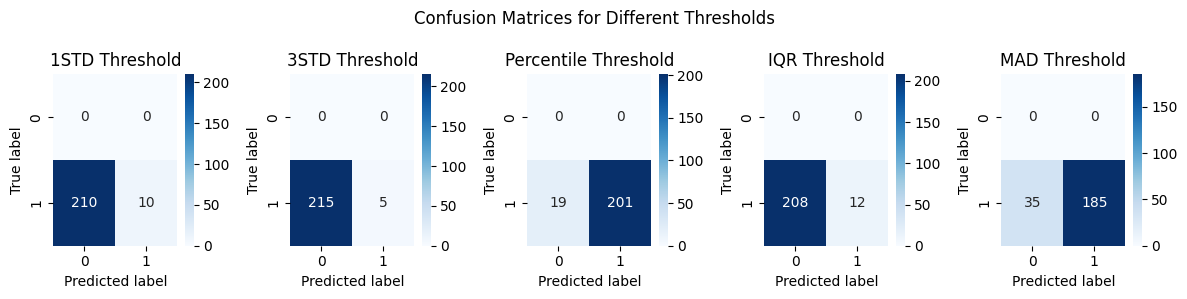

In [57]:
# Create subplots
fig, axs = plt.subplots(1, 5, figsize=(12, 3))

# Iterate over each threshold and label
for i, (threshold, label) in enumerate(zip(thresholds, labels)):
    # Generate predicted labels for the current threshold
    predicted_labels = [int(l >= threshold) for l in rec_loss]

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Plot confusion matrix in the corresponding subplot
    ax = axs[i]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_title(f'{label} Threshold')

# Set the title for the entire figure
fig.suptitle('Confusion Matrices for Different Thresholds')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

### Generate Attack type 3

In [58]:
# For attack type 3
attack_3_windows = []

for window in test_data_windowed:
    attack_window = generate_attack_type_3(window)
    attack_window = scaler.transform(attack_window.reshape(-1, 1))
    attack_3_windows.append(attack_window)
    
# Convert the list of windows to a numpy array and then to a PyTorch tensor
attack_3_windows = np.array(attack_3_windows)
print(attack_3_windows.shape)
attack_3_tensor = torch.Tensor(attack_3_windows)
print(attack_3_tensor.shape)

# Make a DataLoader for each attack type
attack_3_dataloader = DataLoader(attack_3_tensor, batch_size=1, shuffle=False)

(220, 96, 1)
torch.Size([220, 96, 1])


(96, 1)


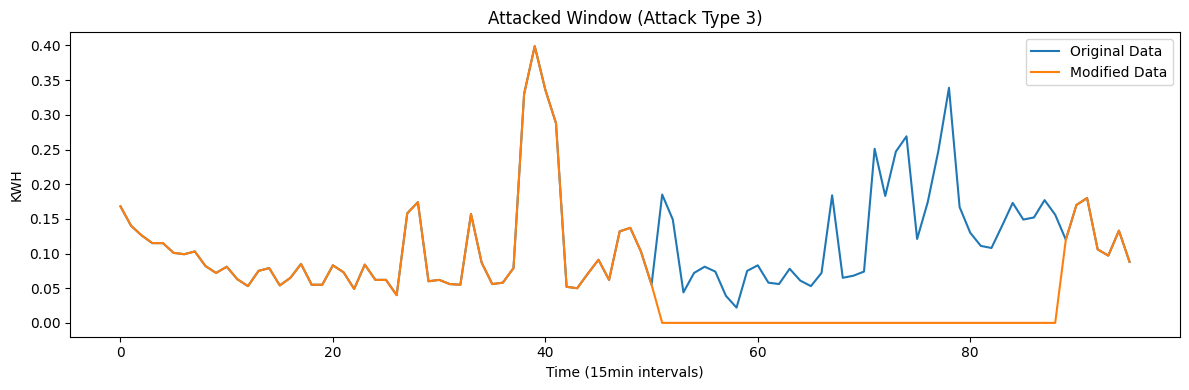

In [59]:
# Select a window
window_index = 0
original_window = test_data_windowed[window_index]

# Apply the attack
attacked_window = generate_attack_type_3(original_window)
print(attacked_window.shape)

# Invert the scaling
original_window_rescaled = scaler.inverse_transform(original_window)
attacked_window_rescaled = scaler.inverse_transform(attacked_window)

# Plot the original and attacked window
plt.figure(figsize=(12, 4))

# Plot the original window
plt.plot(original_window_rescaled)
plt.plot(attacked_window_rescaled)
plt.title('Attacked Window (Attack Type 3)')
plt.xlabel('Time (15min intervals)')
plt.ylabel('KWH')
plt.legend(["Original Data", "Modified Data"])
plt.tight_layout()
plt.show();

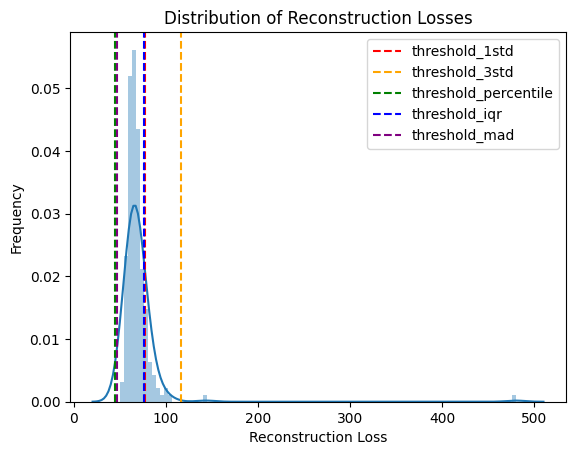

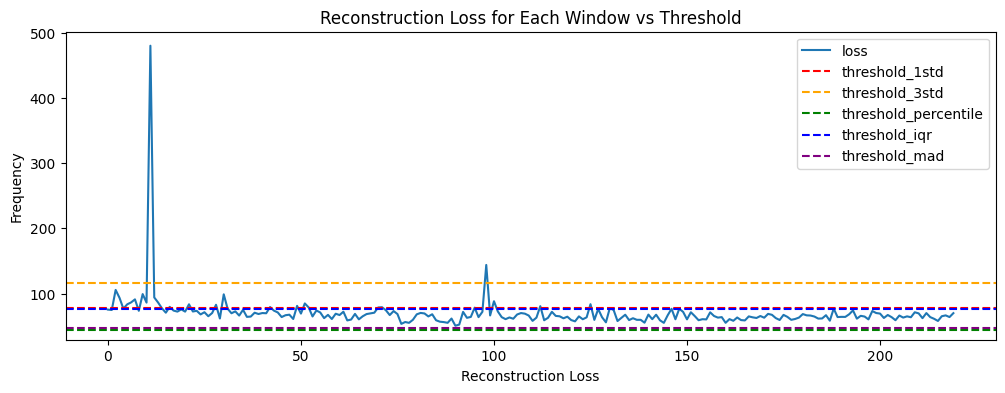

In [60]:
# Get the reconstruction errors for each attack type.
_, rec_error_3, abs_errs_3 = predict(model, attack_3_dataloader)

abs_errs = abs_errs_3

# Plotting the distribution of the reconstruction losses in the training set
sns.distplot(abs_errs, bins=100, kde=True)
plt.axvline(threshold_1std, color='red', linestyle='dashed', label='threshold_1std')
plt.axvline(threshold_3std, color='orange', linestyle='dashed', label='threshold_3std')
plt.axvline(threshold_percentile, color='green', linestyle='dashed', label='threshold_percentile')
plt.axvline(threshold_iqr, color='blue', linestyle='dashed', label='threshold_iqr')
plt.axvline(threshold_mad, color='purple', linestyle='dashed', label='threshold_mad')
plt.xlabel('Reconstruction Loss')
plt.ylabel('Frequency')
plt.title('Distribution of Reconstruction Losses')
plt.legend()
plt.show()

# Loss for each window of the train set vs Threshold
abs_errs_array = np.array(abs_errs).flatten()

plt.figure(figsize=(12,4))
plt.plot(abs_errs_array, label='loss')
plt.axhline(threshold_1std, color='red', linestyle='dashed', label='threshold_1std')
plt.axhline(threshold_3std, color='orange', linestyle='dashed', label='threshold_3std')
plt.axhline(threshold_percentile, color='green', linestyle='dashed', label='threshold_percentile')
plt.axhline(threshold_iqr, color='blue', linestyle='dashed', label='threshold_iqr')
plt.axhline(threshold_mad, color='purple', linestyle='dashed', label='threshold_mad')
plt.title('Reconstruction Loss for Each Window vs Threshold')
plt.xlabel('Reconstruction Loss')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [61]:
rec_loss = abs_errs_3
window_len = attack_3_dataloader

# Anomaly Score -> Standard Deviation Approach
correct = sum(l >= threshold_1std for l in rec_loss)
print(f'Predicted anomalies (1STD): {correct}/{len(window_len)}, ({round((correct*100/len(window_len)),2)}%)')
correct = sum(l >= threshold_3std for l in rec_loss)
print(f'Predicted anomalies (3STD): {correct}/{len(window_len)}, ({round((correct*100/len(window_len)),2)}%)')

# Anomaly Score -> Percentile-Based Approach
correct = sum(l >= threshold_percentile for l in rec_loss)
print(f'Predicted anomalies (Percentile): {correct}/{len(window_len)}, ({round((correct*100/len(window_len)),2)}%)')

# Anomaly Score -> Interquartile Range (IQR) Approach
correct = sum(l >= threshold_iqr for l in rec_loss)
print(f'Predicted anomalies (IQR): {correct}/{len(window_len)}, ({round((correct*100/len(window_len)),2)}%)')

# Anomaly Score -> Median Absolute Deviation Approach(MAD)
correct = sum(l >= threshold_mad for l in rec_loss)
print(f'Predicted anomalies (MAD): {correct}/{len(window_len)}, ({round((correct*100/len(window_len)),2)}%)')

Predicted anomalies (1STD): 26/220, (11.82%)
Predicted anomalies (3STD): 2/220, (0.91%)
Predicted anomalies (Percentile): 220/220, (100.0%)
Predicted anomalies (IQR): 32/220, (14.55%)
Predicted anomalies (MAD): 220/220, (100.0%)


In [62]:
# Generate true labels
true_labels = [1] * len(window_len)   # 1 represents an anomaly

thresholds = [threshold_1std, threshold_3std, threshold_percentile, threshold_iqr, threshold_mad]
labels = ['1STD', '3STD', 'Percentile', 'IQR', 'MAD']

# Iterate over each threshold and label
for threshold, label in zip(thresholds, labels):
    # Generate predicted labels for the current threshold
    predicted_labels = [int(l >= threshold) for l in rec_loss]

    # Compute precision, recall, and F1 score
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)

    # Print the results
    print(f"For {label} threshold:")
    print(f"Precision: {round((precision),2)}")
    print(f"Recall: {round((recall),2)}")
    print(f"F1 score: {round((f1),2)}")
    print()

For 1STD threshold:
Precision: 1.0
Recall: 0.12
F1 score: 0.21

For 3STD threshold:
Precision: 1.0
Recall: 0.01
F1 score: 0.02

For Percentile threshold:
Precision: 1.0
Recall: 1.0
F1 score: 1.0

For IQR threshold:
Precision: 1.0
Recall: 0.15
F1 score: 0.25

For MAD threshold:
Precision: 1.0
Recall: 1.0
F1 score: 1.0



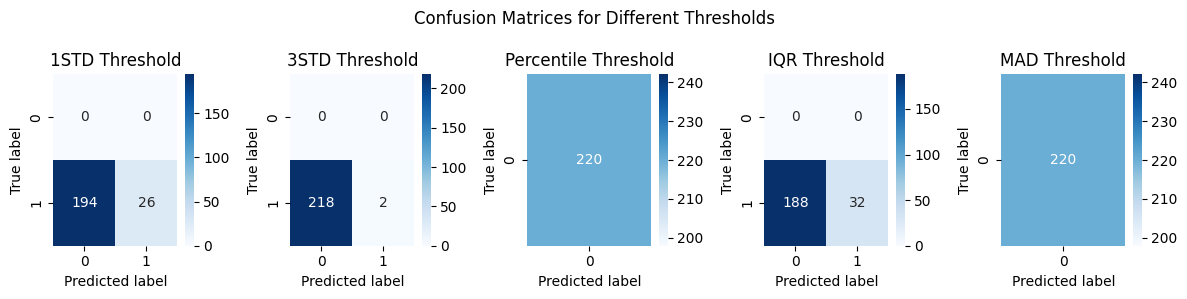

In [63]:
# Create subplots
fig, axs = plt.subplots(1, 5, figsize=(12, 3))

# Iterate over each threshold and label
for i, (threshold, label) in enumerate(zip(thresholds, labels)):
    # Generate predicted labels for the current threshold
    predicted_labels = [int(l >= threshold) for l in rec_loss]

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Plot confusion matrix in the corresponding subplot
    ax = axs[i]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_title(f'{label} Threshold')

# Set the title for the entire figure
fig.suptitle('Confusion Matrices for Different Thresholds')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

### Generate Attack type 4

In [64]:
# For attack type 2
attack_4_windows = []

for window in test_data_windowed:
    attack_window = generate_attack_type_4(window)
    attack_window = scaler.transform(attack_window.reshape(-1, 1))
    attack_4_windows.append(attack_window)
    
# Convert the list of windows to a numpy array and then to a PyTorch tensor
attack_4_windows = np.array(attack_4_windows)
print(attack_4_windows.shape)
attack_4_tensor = torch.Tensor(attack_4_windows)
print(attack_4_tensor.shape)

# Make a DataLoader for each attack type
attack_4_dataloader = DataLoader(attack_4_tensor, batch_size=1, shuffle=False)

(220, 96, 1)
torch.Size([220, 96, 1])


(96, 1)


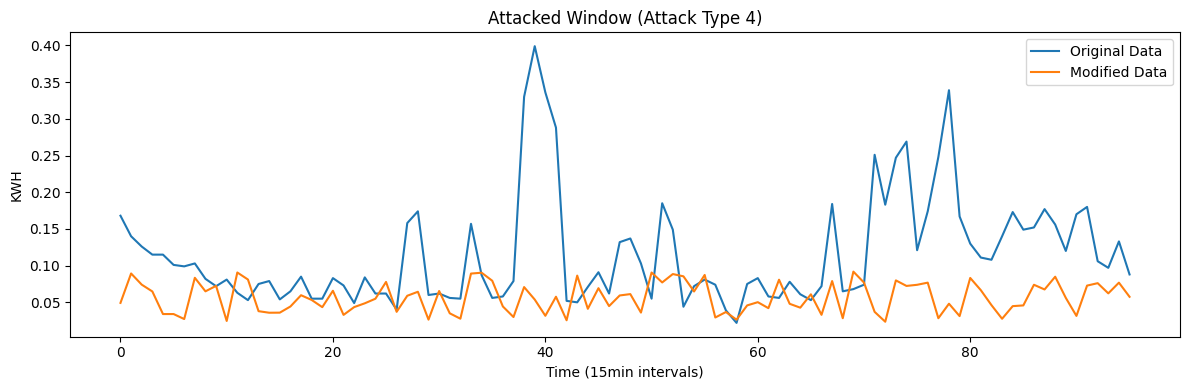

In [65]:
# Select a window
window_index = 0
original_window = test_data_windowed[window_index]

# Apply the attack
attacked_window = generate_attack_type_4(original_window)
print(attacked_window.shape)

# Invert the scaling
original_window_rescaled = scaler.inverse_transform(original_window)
attacked_window_rescaled = scaler.inverse_transform(attacked_window)

# Plot the original and attacked window
plt.figure(figsize=(12, 4))

# Plot the original window
plt.plot(original_window_rescaled)
plt.plot(attacked_window_rescaled)
plt.title('Attacked Window (Attack Type 4)')
plt.xlabel('Time (15min intervals)')
plt.ylabel('KWH')
plt.legend(["Original Data", "Modified Data"])
plt.tight_layout()
plt.show();

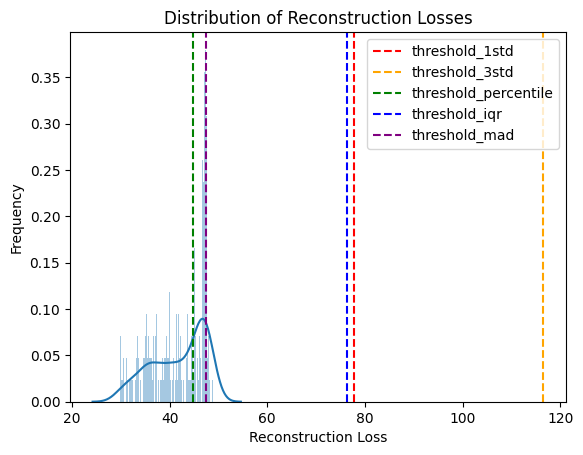

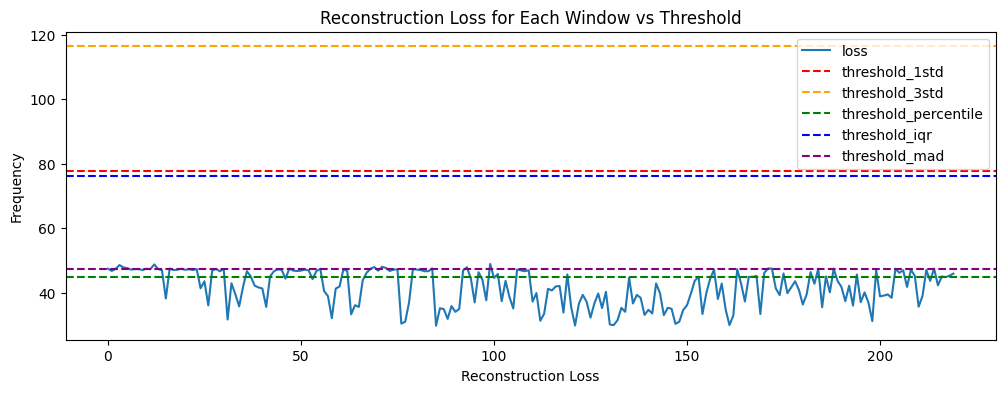

In [66]:
# Get the reconstruction errors for each attack type.
_, rec_error_4, abs_errs_4 = predict(model, attack_4_dataloader)

abs_errs = abs_errs_4

# Plotting the distribution of the reconstruction losses in the training set
sns.distplot(abs_errs, bins=100, kde=True)
plt.axvline(threshold_1std, color='red', linestyle='dashed', label='threshold_1std')
plt.axvline(threshold_3std, color='orange', linestyle='dashed', label='threshold_3std')
plt.axvline(threshold_percentile, color='green', linestyle='dashed', label='threshold_percentile')
plt.axvline(threshold_iqr, color='blue', linestyle='dashed', label='threshold_iqr')
plt.axvline(threshold_mad, color='purple', linestyle='dashed', label='threshold_mad')
plt.xlabel('Reconstruction Loss')
plt.ylabel('Frequency')
plt.title('Distribution of Reconstruction Losses')
plt.legend()
plt.show()

# Loss for each window of the train set vs Threshold
abs_errs_array = np.array(abs_errs).flatten()

plt.figure(figsize=(12,4))
plt.plot(abs_errs_array, label='loss')
plt.axhline(threshold_1std, color='red', linestyle='dashed', label='threshold_1std')
plt.axhline(threshold_3std, color='orange', linestyle='dashed', label='threshold_3std')
plt.axhline(threshold_percentile, color='green', linestyle='dashed', label='threshold_percentile')
plt.axhline(threshold_iqr, color='blue', linestyle='dashed', label='threshold_iqr')
plt.axhline(threshold_mad, color='purple', linestyle='dashed', label='threshold_mad')
plt.title('Reconstruction Loss for Each Window vs Threshold')
plt.xlabel('Reconstruction Loss')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [67]:
rec_loss = abs_errs_4
window_len = attack_4_dataloader

# Anomaly Score -> Standard Deviation Approach
correct = sum(l >= threshold_1std for l in rec_loss)
print(f'Predicted anomalies (1STD): {correct}/{len(window_len)}, ({round((correct*100/len(window_len)),2)}%)')
correct = sum(l >= threshold_3std for l in rec_loss)
print(f'Predicted anomalies (3STD): {correct}/{len(window_len)}, ({round((correct*100/len(window_len)),2)}%)')

# Anomaly Score -> Percentile-Based Approach
correct = sum(l >= threshold_percentile for l in rec_loss)
print(f'Predicted anomalies (Percentile): {correct}/{len(window_len)}, ({round((correct*100/len(window_len)),2)}%)')

# Anomaly Score -> Interquartile Range (IQR) Approach
correct = sum(l >= threshold_iqr for l in rec_loss)
print(f'Predicted anomalies (IQR): {correct}/{len(window_len)}, ({round((correct*100/len(window_len)),2)}%)')

# Anomaly Score -> Median Absolute Deviation Approach(MAD)
correct = sum(l >= threshold_mad for l in rec_loss)
print(f'Predicted anomalies (MAD): {correct}/{len(window_len)}, ({round((correct*100/len(window_len)),2)}%)')

Predicted anomalies (1STD): 0/220, (0.0%)
Predicted anomalies (3STD): 0/220, (0.0%)
Predicted anomalies (Percentile): 95/220, (43.18%)
Predicted anomalies (IQR): 0/220, (0.0%)
Predicted anomalies (MAD): 30/220, (13.64%)


In [68]:
# Generate true labels
true_labels = [1] * len(window_len)   # 1 represents an anomaly

thresholds = [threshold_1std, threshold_3std, threshold_percentile, threshold_iqr, threshold_mad]
labels = ['1STD', '3STD', 'Percentile', 'IQR', 'MAD']

# Iterate over each threshold and label
for threshold, label in zip(thresholds, labels):
    # Generate predicted labels for the current threshold
    predicted_labels = [int(l >= threshold) for l in rec_loss]

    # Compute precision, recall, and F1 score
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)

    # Print the results
    print(f"For {label} threshold:")
    print(f"Precision: {round((precision),2)}")
    print(f"Recall: {round((recall),2)}")
    print(f"F1 score: {round((f1),2)}")
    print()

For 1STD threshold:
Precision: 0.0
Recall: 0.0
F1 score: 0.0

For 3STD threshold:
Precision: 0.0
Recall: 0.0
F1 score: 0.0

For Percentile threshold:
Precision: 1.0
Recall: 0.43
F1 score: 0.6

For IQR threshold:
Precision: 0.0
Recall: 0.0
F1 score: 0.0

For MAD threshold:
Precision: 1.0
Recall: 0.14
F1 score: 0.24



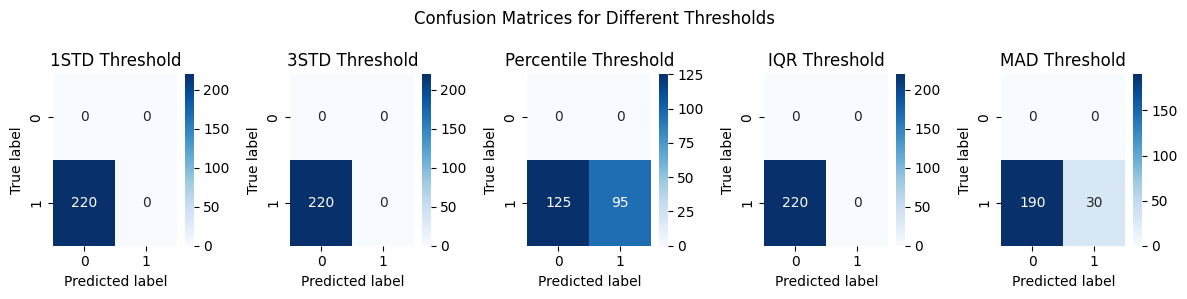

In [69]:
# Create subplots
fig, axs = plt.subplots(1, 5, figsize=(12, 3))

# Iterate over each threshold and label
for i, (threshold, label) in enumerate(zip(thresholds, labels)):
    # Generate predicted labels for the current threshold
    predicted_labels = [int(l >= threshold) for l in rec_loss]

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Plot confusion matrix in the corresponding subplot
    ax = axs[i]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_title(f'{label} Threshold')

# Set the title for the entire figure
fig.suptitle('Confusion Matrices for Different Thresholds')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

### Generate Attack type 5

In [70]:
# For attack type 2
attack_5_windows = []

for window in test_data_windowed:
    attack_window = generate_attack_type_5(window)
    attack_window = scaler.transform(attack_window.reshape(-1, 1))
    attack_5_windows.append(attack_window)
    
# Convert the list of windows to a numpy array and then to a PyTorch tensor
attack_5_windows = np.array(attack_5_windows)
print(attack_5_windows.shape)
attack_5_tensor = torch.Tensor(attack_5_windows)
print(attack_5_tensor.shape)

# Make a DataLoader for each attack type
attack_5_dataloader = DataLoader(attack_5_tensor, batch_size=1, shuffle=False)

(220, 96, 1)
torch.Size([220, 96, 1])


(96, 1)


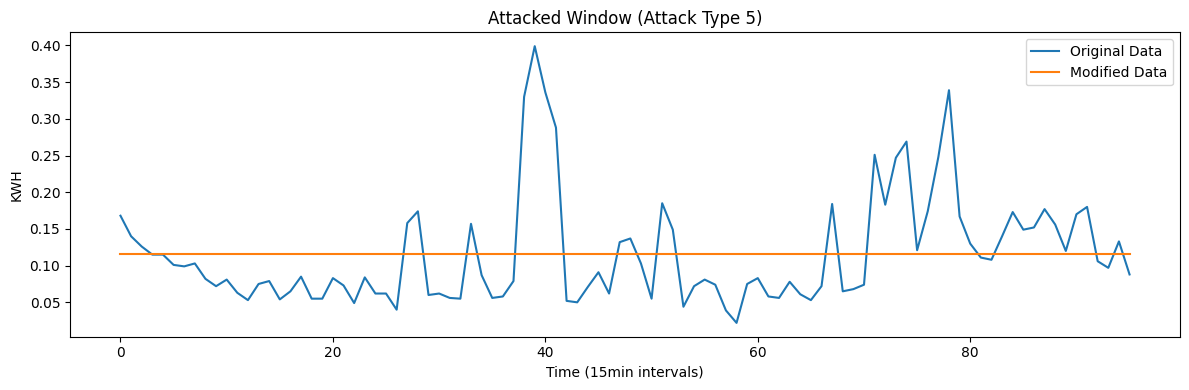

In [71]:
# Select a window
window_index = 0
original_window = test_data_windowed[window_index]

# Apply the attack
attacked_window = generate_attack_type_5(original_window)
print(attacked_window.shape)

# Invert the scaling
original_window_rescaled = scaler.inverse_transform(original_window)
attacked_window_rescaled = scaler.inverse_transform(attacked_window)

# Plot the original and attacked window
plt.figure(figsize=(12, 4))

# Plot the original window
plt.plot(original_window_rescaled)
plt.plot(attacked_window_rescaled)
plt.title('Attacked Window (Attack Type 5)')
plt.xlabel('Time (15min intervals)')
plt.ylabel('KWH')
plt.legend(["Original Data", "Modified Data"])
plt.tight_layout()
plt.show();

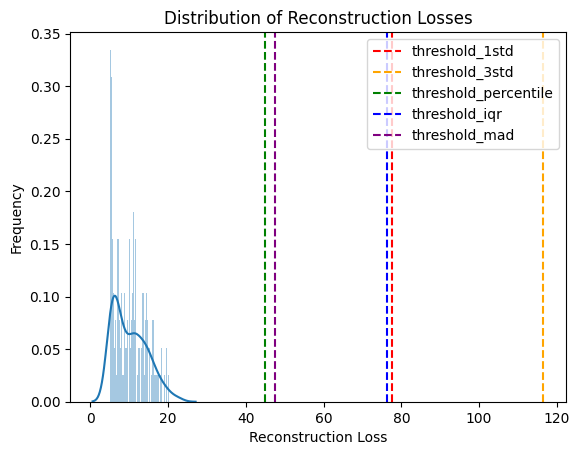

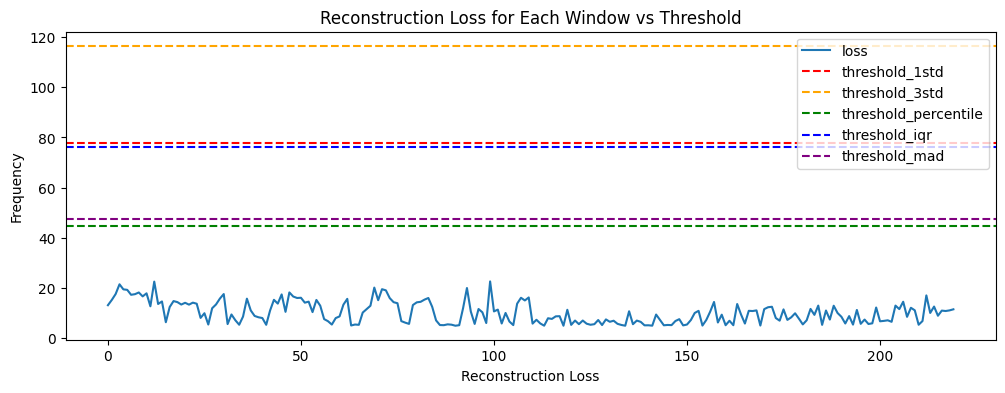

In [72]:
# Get the reconstruction errors for each attack type.
_, rec_error_5, abs_errs_5 = predict(model, attack_5_dataloader)

abs_errs = abs_errs_5

# Plotting the distribution of the reconstruction losses in the training set
sns.distplot(abs_errs, bins=100, kde=True)
plt.axvline(threshold_1std, color='red', linestyle='dashed', label='threshold_1std')
plt.axvline(threshold_3std, color='orange', linestyle='dashed', label='threshold_3std')
plt.axvline(threshold_percentile, color='green', linestyle='dashed', label='threshold_percentile')
plt.axvline(threshold_iqr, color='blue', linestyle='dashed', label='threshold_iqr')
plt.axvline(threshold_mad, color='purple', linestyle='dashed', label='threshold_mad')
plt.xlabel('Reconstruction Loss')
plt.ylabel('Frequency')
plt.title('Distribution of Reconstruction Losses')
plt.legend()
plt.show()

# Loss for each window of the train set vs Threshold
abs_errs_array = np.array(abs_errs).flatten()

plt.figure(figsize=(12,4))
plt.plot(abs_errs_array, label='loss')
plt.axhline(threshold_1std, color='red', linestyle='dashed', label='threshold_1std')
plt.axhline(threshold_3std, color='orange', linestyle='dashed', label='threshold_3std')
plt.axhline(threshold_percentile, color='green', linestyle='dashed', label='threshold_percentile')
plt.axhline(threshold_iqr, color='blue', linestyle='dashed', label='threshold_iqr')
plt.axhline(threshold_mad, color='purple', linestyle='dashed', label='threshold_mad')
plt.title('Reconstruction Loss for Each Window vs Threshold')
plt.xlabel('Reconstruction Loss')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [73]:
rec_loss = abs_errs_5
window_len = attack_5_dataloader

# Anomaly Score -> Standard Deviation Approach
correct = sum(l >= threshold_1std for l in rec_loss)
print(f'Predicted anomalies (1STD): {correct}/{len(window_len)}, ({round((correct*100/len(window_len)),2)}%)')
correct = sum(l >= threshold_3std for l in rec_loss)
print(f'Predicted anomalies (3STD): {correct}/{len(window_len)}, ({round((correct*100/len(window_len)),2)}%)')

# Anomaly Score -> Percentile-Based Approach
correct = sum(l >= threshold_percentile for l in rec_loss)
print(f'Predicted anomalies (Percentile): {correct}/{len(window_len)}, ({round((correct*100/len(window_len)),2)}%)')

# Anomaly Score -> Interquartile Range (IQR) Approach
correct = sum(l >= threshold_iqr for l in rec_loss)
print(f'Predicted anomalies (IQR): {correct}/{len(window_len)}, ({round((correct*100/len(window_len)),2)}%)')

# Anomaly Score -> Median Absolute Deviation Approach(MAD)
correct = sum(l >= threshold_mad for l in rec_loss)
print(f'Predicted anomalies (MAD): {correct}/{len(window_len)}, ({round((correct*100/len(window_len)),2)}%)')

Predicted anomalies (1STD): 0/220, (0.0%)
Predicted anomalies (3STD): 0/220, (0.0%)
Predicted anomalies (Percentile): 0/220, (0.0%)
Predicted anomalies (IQR): 0/220, (0.0%)
Predicted anomalies (MAD): 0/220, (0.0%)


In [74]:
# Generate true labels
true_labels = [1] * len(window_len)   # 1 represents an anomaly

thresholds = [threshold_1std, threshold_3std, threshold_percentile, threshold_iqr, threshold_mad]
labels = ['1STD', '3STD', 'Percentile', 'IQR', 'MAD']

# Iterate over each threshold and label
for threshold, label in zip(thresholds, labels):
    # Generate predicted labels for the current threshold
    predicted_labels = [int(l >= threshold) for l in rec_loss]

    # Compute precision, recall, and F1 score
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)

    # Print the results
    print(f"For {label} threshold:")
    print(f"Precision: {round((precision),2)}")
    print(f"Recall: {round((recall),2)}")
    print(f"F1 score: {round((f1),2)}")
    print()

For 1STD threshold:
Precision: 0.0
Recall: 0.0
F1 score: 0.0

For 3STD threshold:
Precision: 0.0
Recall: 0.0
F1 score: 0.0

For Percentile threshold:
Precision: 0.0
Recall: 0.0
F1 score: 0.0

For IQR threshold:
Precision: 0.0
Recall: 0.0
F1 score: 0.0

For MAD threshold:
Precision: 0.0
Recall: 0.0
F1 score: 0.0



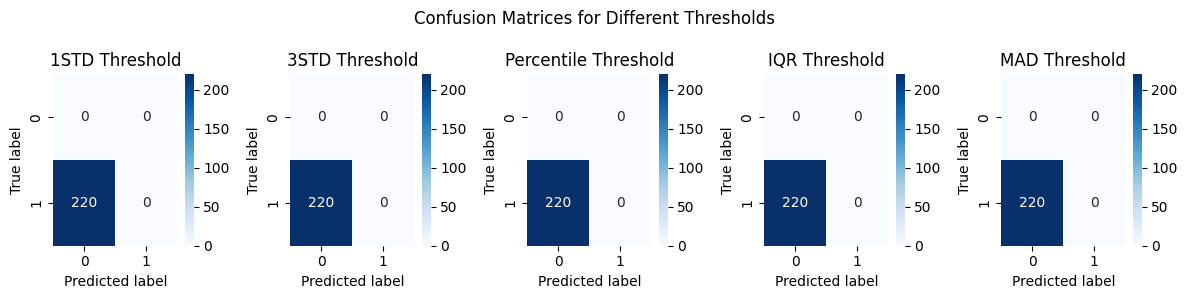

In [75]:
# Create subplots
fig, axs = plt.subplots(1, 5, figsize=(12, 3))

# Iterate over each threshold and label
for i, (threshold, label) in enumerate(zip(thresholds, labels)):
    # Generate predicted labels for the current threshold
    predicted_labels = [int(l >= threshold) for l in rec_loss]

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Plot confusion matrix in the corresponding subplot
    ax = axs[i]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_title(f'{label} Threshold')

# Set the title for the entire figure
fig.suptitle('Confusion Matrices for Different Thresholds')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

### Generate Attack type 6

In [76]:
# For attack type 2
attack_6_windows = []

for window in test_data_windowed:
    attack_window = generate_attack_type_6(window)
    attack_window = scaler.transform(attack_window.reshape(-1, 1))
    attack_6_windows.append(attack_window)
    
# Convert the list of windows to a numpy array and then to a PyTorch tensor
attack_6_windows = np.array(attack_6_windows)
print(attack_6_windows.shape)
attack_6_tensor = torch.Tensor(attack_6_windows)
print(attack_6_tensor.shape)

# Make a DataLoader for each attack type
attack_6_dataloader = DataLoader(attack_6_tensor, batch_size=1, shuffle=False)

(220, 96, 1)
torch.Size([220, 96, 1])


(96, 1)


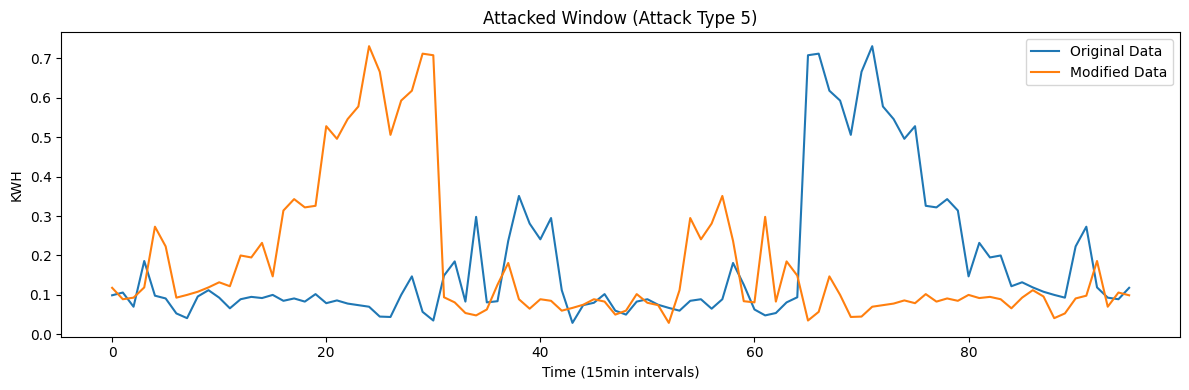

In [77]:
# Select a window
window_index = 15
original_window = test_data_windowed[window_index]

# Apply the attack
attacked_window = generate_attack_type_6(original_window)
print(attacked_window.shape)

# Invert the scaling
original_window_rescaled = scaler.inverse_transform(original_window)
attacked_window_rescaled = scaler.inverse_transform(attacked_window)

# Plot the original and attacked window
plt.figure(figsize=(12, 4))

# Plot the original window
plt.plot(original_window_rescaled)
plt.plot(attacked_window_rescaled)
plt.title('Attacked Window (Attack Type 5)')
plt.xlabel('Time (15min intervals)')
plt.ylabel('KWH')
plt.legend(["Original Data", "Modified Data"])
plt.tight_layout()
plt.show();

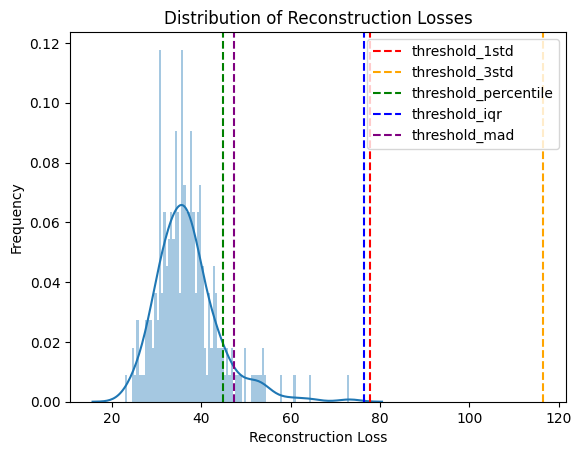

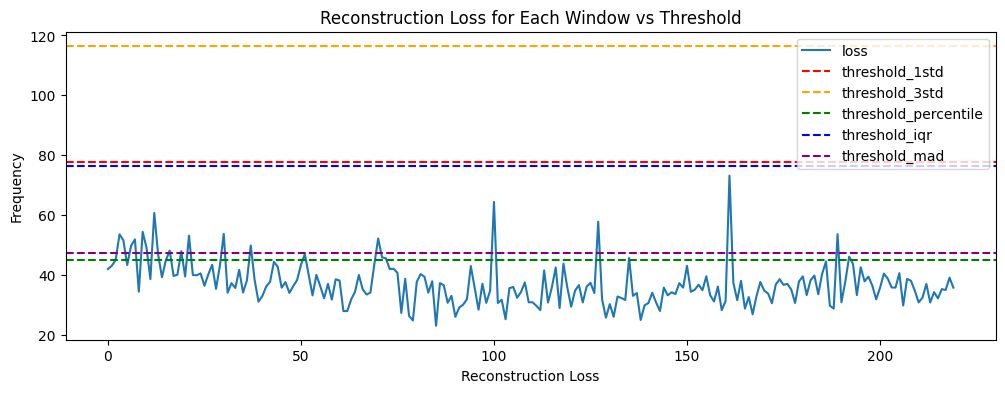

In [78]:
# Get the reconstruction errors for each attack type.
_, rec_error_6, abs_errs_6 = predict(model, attack_6_dataloader)

abs_errs = abs_errs_6

# Plotting the distribution of the reconstruction losses in the training set
sns.distplot(abs_errs, bins=100, kde=True)
plt.axvline(threshold_1std, color='red', linestyle='dashed', label='threshold_1std')
plt.axvline(threshold_3std, color='orange', linestyle='dashed', label='threshold_3std')
plt.axvline(threshold_percentile, color='green', linestyle='dashed', label='threshold_percentile')
plt.axvline(threshold_iqr, color='blue', linestyle='dashed', label='threshold_iqr')
plt.axvline(threshold_mad, color='purple', linestyle='dashed', label='threshold_mad')
plt.xlabel('Reconstruction Loss')
plt.ylabel('Frequency')
plt.title('Distribution of Reconstruction Losses')
plt.legend()
plt.show()

# Loss for each window of the train set vs Threshold
abs_errs_array = np.array(abs_errs).flatten()

plt.figure(figsize=(12,4))
plt.plot(abs_errs_array, label='loss')
plt.axhline(threshold_1std, color='red', linestyle='dashed', label='threshold_1std')
plt.axhline(threshold_3std, color='orange', linestyle='dashed', label='threshold_3std')
plt.axhline(threshold_percentile, color='green', linestyle='dashed', label='threshold_percentile')
plt.axhline(threshold_iqr, color='blue', linestyle='dashed', label='threshold_iqr')
plt.axhline(threshold_mad, color='purple', linestyle='dashed', label='threshold_mad')
plt.title('Reconstruction Loss for Each Window vs Threshold')
plt.xlabel('Reconstruction Loss')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [79]:
rec_loss = abs_errs_6
window_len = attack_6_dataloader

# Anomaly Score -> Standard Deviation Approach
correct = sum(l >= threshold_1std for l in rec_loss)
print(f'Predicted anomalies (1STD): {correct}/{len(window_len)}, ({round((correct*100/len(window_len)),2)}%)')
correct = sum(l >= threshold_3std for l in rec_loss)
print(f'Predicted anomalies (3STD): {correct}/{len(window_len)}, ({round((correct*100/len(window_len)),2)}%)')

# Anomaly Score -> Percentile-Based Approach
correct = sum(l >= threshold_percentile for l in rec_loss)
print(f'Predicted anomalies (Percentile): {correct}/{len(window_len)}, ({round((correct*100/len(window_len)),2)}%)')

# Anomaly Score -> Interquartile Range (IQR) Approach
correct = sum(l >= threshold_iqr for l in rec_loss)
print(f'Predicted anomalies (IQR): {correct}/{len(window_len)}, ({round((correct*100/len(window_len)),2)}%)')

# Anomaly Score -> Median Absolute Deviation Approach(MAD)
correct = sum(l >= threshold_mad for l in rec_loss)
print(f'Predicted anomalies (MAD): {correct}/{len(window_len)}, ({round((correct*100/len(window_len)),2)}%)')

Predicted anomalies (1STD): 0/220, (0.0%)
Predicted anomalies (3STD): 0/220, (0.0%)
Predicted anomalies (Percentile): 24/220, (10.91%)
Predicted anomalies (IQR): 0/220, (0.0%)
Predicted anomalies (MAD): 17/220, (7.73%)


In [80]:
# Generate true labels
true_labels = [1] * len(window_len)   # 1 represents an anomaly

thresholds = [threshold_1std, threshold_3std, threshold_percentile, threshold_iqr, threshold_mad]
labels = ['1STD', '3STD', 'Percentile', 'IQR', 'MAD']

# Iterate over each threshold and label
for threshold, label in zip(thresholds, labels):
    # Generate predicted labels for the current threshold
    predicted_labels = [int(l >= threshold) for l in rec_loss]

    # Compute precision, recall, and F1 score
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)

    # Print the results
    print(f"For {label} threshold:")
    print(f"Precision: {round((precision),2)}")
    print(f"Recall: {round((recall),2)}")
    print(f"F1 score: {round((f1),2)}")
    print()

For 1STD threshold:
Precision: 0.0
Recall: 0.0
F1 score: 0.0

For 3STD threshold:
Precision: 0.0
Recall: 0.0
F1 score: 0.0

For Percentile threshold:
Precision: 1.0
Recall: 0.11
F1 score: 0.2

For IQR threshold:
Precision: 0.0
Recall: 0.0
F1 score: 0.0

For MAD threshold:
Precision: 1.0
Recall: 0.08
F1 score: 0.14



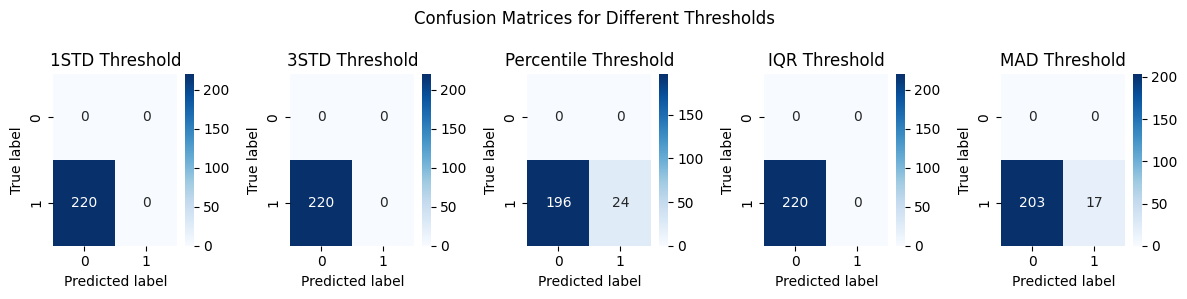

In [81]:
# Create subplots
fig, axs = plt.subplots(1, 5, figsize=(12, 3))

# Iterate over each threshold and label
for i, (threshold, label) in enumerate(zip(thresholds, labels)):
    # Generate predicted labels for the current threshold
    predicted_labels = [int(l >= threshold) for l in rec_loss]

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Plot confusion matrix in the corresponding subplot
    ax = axs[i]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_title(f'{label} Threshold')

# Set the title for the entire figure
fig.suptitle('Confusion Matrices for Different Thresholds')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

# Testing on all users

In [82]:
users_for_test = pd.read_csv('datasets/datafortesting/user_for_test.csv')
users_for_test = users_for_test[users_for_test['user'] != 850]
users_for_test = users_for_test.sort_values('user')
print(users_for_test['user'].unique())
users_for_test

[  22   50   80   85  101  119  139  183  287  292  357  359  362  395
  396  418  419  438  439  446  452  492  493  497  517  528  530  643
  687  775  776  852  855  859  885  911  952  954 1014 1077 1088 1115
 1155 1157 1158 1160 1195 1283 1345 1349 1350 1351 1418 1427 1440 1463
 1472 1476 1497 1501 1506 1539 1582 1591 1639 1643 1664 1695 1697 1708
 1727 1728 1736 1746 1756 1840 1858 1883 1889 1896 1918 1943 1949 1959
 1960 1962 1971]


MeterID            DATE-Time    KWH  user
0        6200063350  2021-01-01 00:00:00  0.168    22
15226    6200063350  2021-06-13 18:30:00  0.096    22
15225    6200063350  2021-06-13 18:15:00  0.130    22
15224    6200063350  2021-06-13 18:00:00  0.141    22
15223    6200063350  2021-06-13 17:45:00  0.145    22
...             ...                  ...    ...   ...
1757674  6200046515  2021-03-11 20:15:00  0.113  1971
1757673  6200046515  2021-03-11 20:00:00  1.254  1971
1757672  6200046515  2021-03-11 19:45:00  1.028  1971
1757679  6200046515  2021-03-11 21:30:00  0.575  1971
1770808  6200046515  2021-07-31 23:45:00  0.611  1971

[1750585 rows x 4 columns]

In [83]:
users_for_test_list = users_for_test['user'].unique().tolist()
len(users_for_test_list)

87

In [84]:
def create_windowed_dataset(data, window_size):
    # Calculate the number of windows that fit in the data
    num_windows = len(data) // window_size
    
    # Truncate data to fit into windowed data exactly
    data = data[:num_windows*window_size]
    
    # Reshape the data into a 3D tensor of (num_windows, window_size, num_features)
    # Here we're adding an extra dimension to the data to represent the features, which is 1 in our case
    windowed_data = np.reshape(data, (num_windows, window_size, 1))
    
    return windowed_data

def normalize_and_create_windowed_test_data(data, window_size=96, RANDOM_SEED=42):
    # Initialize a MinMaxScaler object
    scaler = MinMaxScaler()

    # Fit the scaler to the data and transform it
    data_normalized = scaler.fit_transform(data)

    # Create windowed datasets
    data_windowed = create_windowed_dataset(data_normalized, window_size)

    return data_windowed, scaler

In [85]:
results = pd.DataFrame(columns=['User', 'Attack_Type','Num_Sample',
                                '1STD', '3STD', 'Percentile', 'IQR', 'MAD', 
                                'Precision_1STD', 'Recall_1STD', 'F1_1STD',
                                'Precision_3STD', 'Recall_3STD', 'F1_3STD',
                                'Precision_Percentile', 'Recall_Percentile', 'F1_Percentile',
                                'Precision_IQR', 'Recall_IQR', 'F1_IQR',
                                'Precision_MAD', 'Recall_MAD', 'F1_MAD'])

In [86]:
def evaluate_attack_type(attack_type, windowed_data, scaler, model, thresholds):
    attack_windows = []

    for window in windowed_data:
        if attack_type == 1:
            attack_window = generate_attack_type_1(window)
        elif attack_type == 2:
            attack_window = generate_attack_type_2(window)
        elif attack_type == 3:
            attack_window = generate_attack_type_3(window)
        elif attack_type == 4:
            attack_window = generate_attack_type_4(window)
        elif attack_type == 5:
            attack_window = generate_attack_type_5(window)
        elif attack_type == 6:
            attack_window = generate_attack_type_6(window)

        attack_window = scaler.transform(attack_window.reshape(-1, 1))
        attack_windows.append(attack_window)

    attack_windows = np.array(attack_windows)
    attack_tensor = torch.Tensor(attack_windows)

    attack_dataloader = DataLoader(attack_tensor, batch_size=1, shuffle=False)

    _, rec_error, abs_errs = predict(model, attack_dataloader)
    rec_loss = abs_errs
    window_len = attack_dataloader

    results_dict = {}

    for idx, threshold in enumerate(thresholds):
        correct = sum(l >= threshold for l in rec_loss)
        results_dict['correct_' + str(idx)] = correct

        true_labels = [1] * len(window_len)
        predicted_labels = [int(l >= threshold) for l in rec_loss]

        precision = precision_score(true_labels, predicted_labels)
        recall = recall_score(true_labels, predicted_labels)
        f1 = f1_score(true_labels, predicted_labels)

        results_dict['precision_' + str(idx)] = precision
        results_dict['recall_' + str(idx)] = recall
        results_dict['f1_' + str(idx)] = f1

    return results_dict

In [87]:
for user in tqdm(users_for_test_list):
    # Subset the DataFrame for the current user
    user_data = users_for_test[users_for_test['user'] == user]

    # Clean the data for the current user
    cleaned_data = clean_data(user_data, user)

    # Normalize and window the data
    test_data_windowed, scaler = normalize_and_create_windowed_test_data(cleaned_data)

    for attack_type in range(1, 7):  # Assuming you have 6 attack types
        result_dict = evaluate_attack_type(attack_type, test_data_windowed, scaler, model, thresholds)
        
        result_dict['User'] = int(user) # This is the current user
        result_dict['Attack_Type'] = int(attack_type)
        result_dict['Num_Sample'] = int(len(test_data_windowed))  # Or whatever number is appropriate

        # Same key renaming as before
        result_dict['1STD'] = result_dict.pop('correct_0')
        result_dict['3STD'] = result_dict.pop('correct_1')
        result_dict['Percentile'] = result_dict.pop('correct_2')
        result_dict['IQR'] = result_dict.pop('correct_3')
        result_dict['MAD'] = result_dict.pop('correct_4')

        result_dict['Precision_1STD'] = result_dict.pop('precision_0')
        result_dict['Recall_1STD'] = result_dict.pop('recall_0')
        result_dict['F1_1STD'] = result_dict.pop('f1_0')

        result_dict['Precision_3STD'] = result_dict.pop('precision_1')
        result_dict['Recall_3STD'] = result_dict.pop('recall_1')
        result_dict['F1_3STD'] = result_dict.pop('f1_1')

        result_dict['Precision_Percentile'] = result_dict.pop('precision_2')
        result_dict['Recall_Percentile'] = result_dict.pop('recall_2')
        result_dict['F1_Percentile'] = result_dict.pop('f1_2')

        result_dict['Precision_IQR'] = result_dict.pop('precision_3')
        result_dict['Recall_IQR'] = result_dict.pop('recall_3')
        result_dict['F1_IQR'] = result_dict.pop('f1_3')

        result_dict['Precision_MAD'] = result_dict.pop('precision_4')
        result_dict['Recall_MAD'] = result_dict.pop('recall_4')
        result_dict['F1_MAD'] = result_dict.pop('f1_4')
        
        # Append the result_dict to your DataFrame
        results = results.append(result_dict, ignore_index=True)

100%|██████████| 87/87 [05:35<00:00,  3.86s/it]


In [88]:
results

User  Attack_Type  Num_Sample  1STD  3STD  Percentile   IQR    MAD  \
0      22.0          1.0       220.0  14.0   3.0       127.0  14.0   91.0   
1      22.0          2.0       220.0  10.0   5.0       201.0  12.0  185.0   
2      22.0          3.0       220.0  26.0   2.0       220.0  32.0  220.0   
3      22.0          4.0       220.0   0.0   0.0        95.0   0.0   30.0   
4      22.0          5.0       220.0   0.0   0.0         0.0   0.0    0.0   
..      ...          ...         ...   ...   ...         ...   ...    ...   
517  1971.0          2.0       200.0   0.0   0.0       177.0   0.0  157.0   
518  1971.0          3.0       200.0   1.0   1.0       200.0   3.0  200.0   
519  1971.0          4.0       200.0   0.0   0.0       107.0   0.0   37.0   
520  1971.0          5.0       200.0   0.0   0.0         0.0   0.0    0.0   
521  1971.0          6.0       200.0   0.0   0.0         7.0   0.0    4.0   

     Precision_1STD  Recall_1STD  ...   F1_3STD  Precision_Percentile  \
0               1.0     0.063636  ...  0.026906                   1.0   
1               1.0     0.045455  ...  0.044444                   1.0   
2               1.0     0.118182  ...  0.018018                   1.0   
3               0.0     0.000000  ...  0.000000                   1.0   
4               0.0     0.000000  ...  0.000000                   0.0   
..              ...          ...  ...       ...                   ...   
517             0.0     0.000000  ...  0.000000                   1.0   
518             1.0     0.005000  ...  0.009950                   1.0   
519             0.0     0.000000  ...  0.000000                   1.0   
520             0.0     0.000000  ...  0.000000                   0.0   
521             0.0     0.000000  ...  0.000000                   1.0   

     Recall_Percentile  F1_Percentile  Precision_IQR  Recall_IQR    F1_IQR  \
0             0.577273       0.731988            1.0    0.063636  0.119658   
1             0.913636       0.954869            1.0    0.054545  0.103448   
2             1.000000       1.000000            1.0    0.145455  0.253968   
3             0.431818       0.603175            0.0    0.000000  0.000000   
4             0.000000       0.000000            0.0    0.000000  0.000000   
..                 ...            ...            ...         ...       ...   
517           0.885000       0.938992            0.0    0.000000  0.000000   
518           1.000000       1.000000            1.0    0.015000  0.029557   
519           0.535000       0.697068            0.0    0.000000  0.000000   
520           0.000000       0.000000            0.0    0.000000  0.000000   
521           0.035000       0.067633            0.0    0.000000  0.000000   

     Precision_MAD  Recall_MAD    F1_MAD  
0              1.0    0.413636  0.585209  
1              1.0    0.840909  0.913580  
2              1.0    1.000000  1.000000  
3              1.0    0.136364  0.240000  
4              0.0    0.000000  0.000000  
..             ...         ...       ...  
517            1.0    0.785000  0.879552  
518            1.0    1.000000  1.000000  
519            1.0    0.185000  0.312236  
520            0.0    0.000000  0.000000  
521            1.0    0.020000  0.039216  

[522 rows x 23 columns]

In [89]:
results.to_csv('datasets/result/AE_10u.csv', index=False)

### Looking at Examples

In [53]:
def plot_prediction(data, model, title, ax):
    predictions, pred_losses = predict(model, [data])

    ax.plot(data, label='true')
    ax.plot(predictions[0], label='reconstructed')
    ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
    
    # ax[1].imshow(np.atleast_2d(pred_losses), aspect=5, cmap='Wistia')
    # ax[1].set_xticks([])
    # ax[1].set_yticks([])
    
    ax.legend()

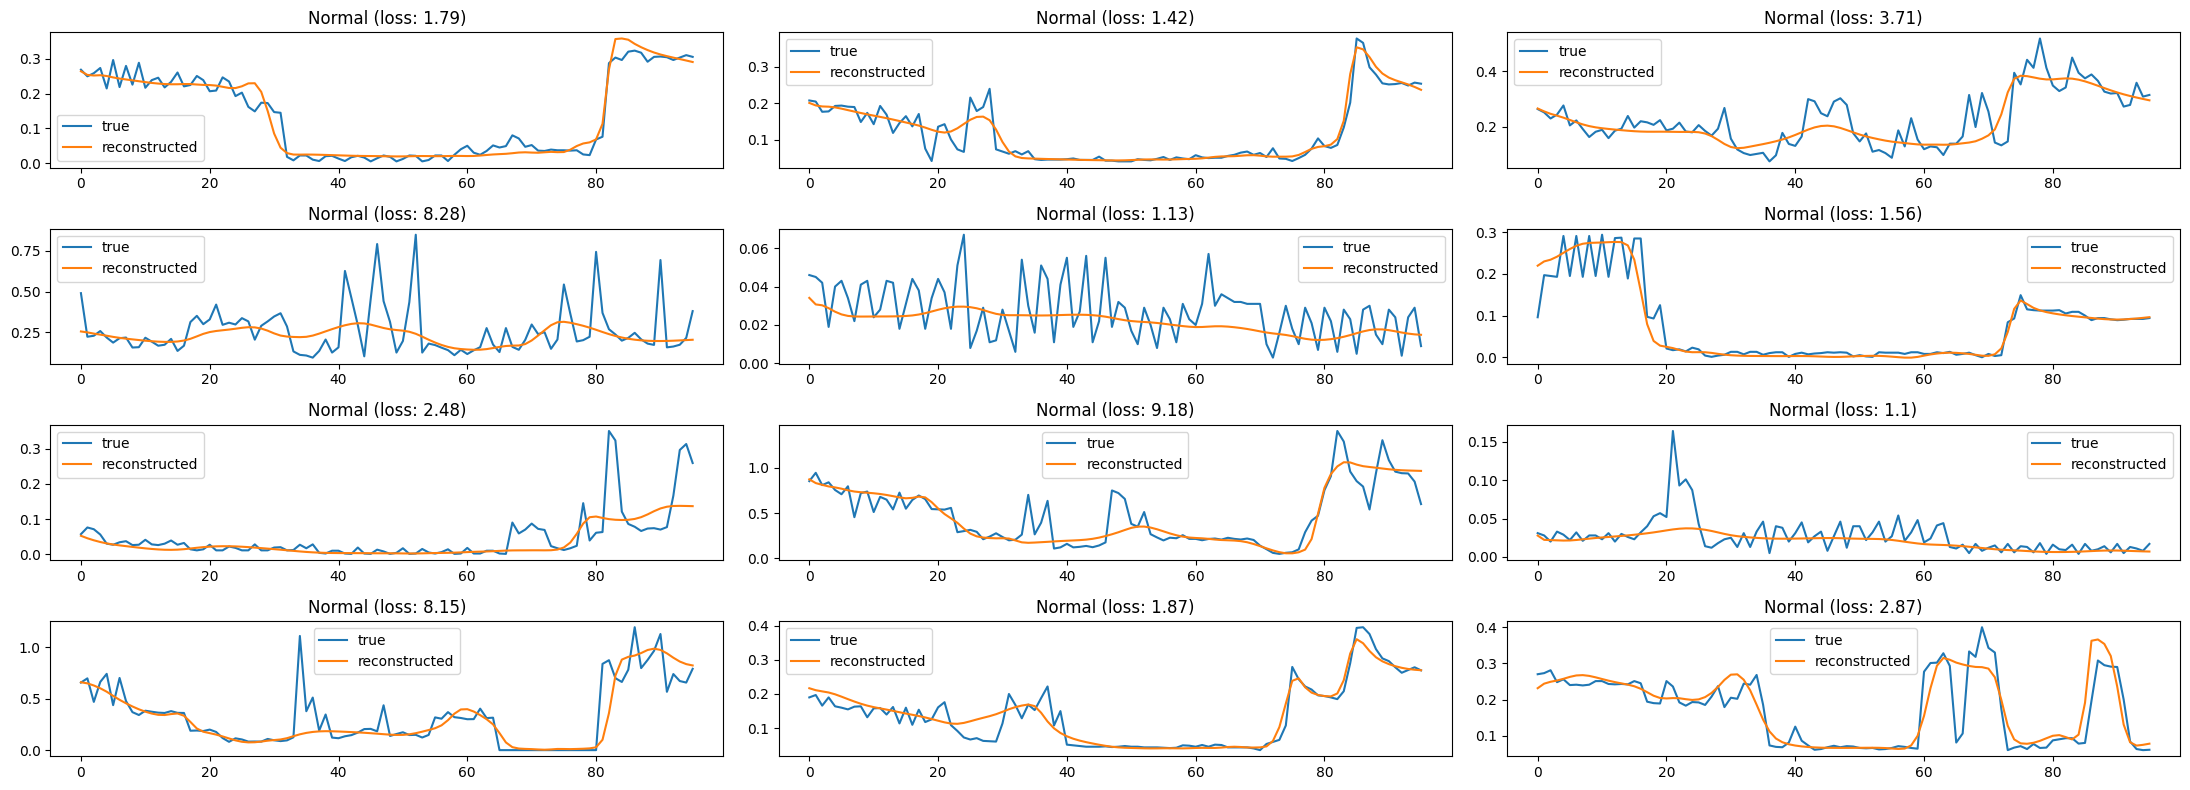

In [54]:
# In Training
fig, axs = plt.subplots(
  nrows=4,
  ncols=3,
  # sharey=True,
  # sharex=True,
  figsize=(22, 8)
)

for i, data in enumerate(train_dataset[0:3]):
    plot_prediction(data, model, title='Normal', ax=axs[0, i])
    
for i, data in enumerate(train_dataset[3:6]):
    plot_prediction(data, model, title='Normal', ax=axs[1, i])
    
for i, data in enumerate(train_dataset[6:9]):
    plot_prediction(data, model, title='Normal', ax=axs[2, i])
    
for i, data in enumerate(train_dataset[9:12]):
    plot_prediction(data, model, title='Normal', ax=axs[3, i])

plt.tight_layout()

### Testing

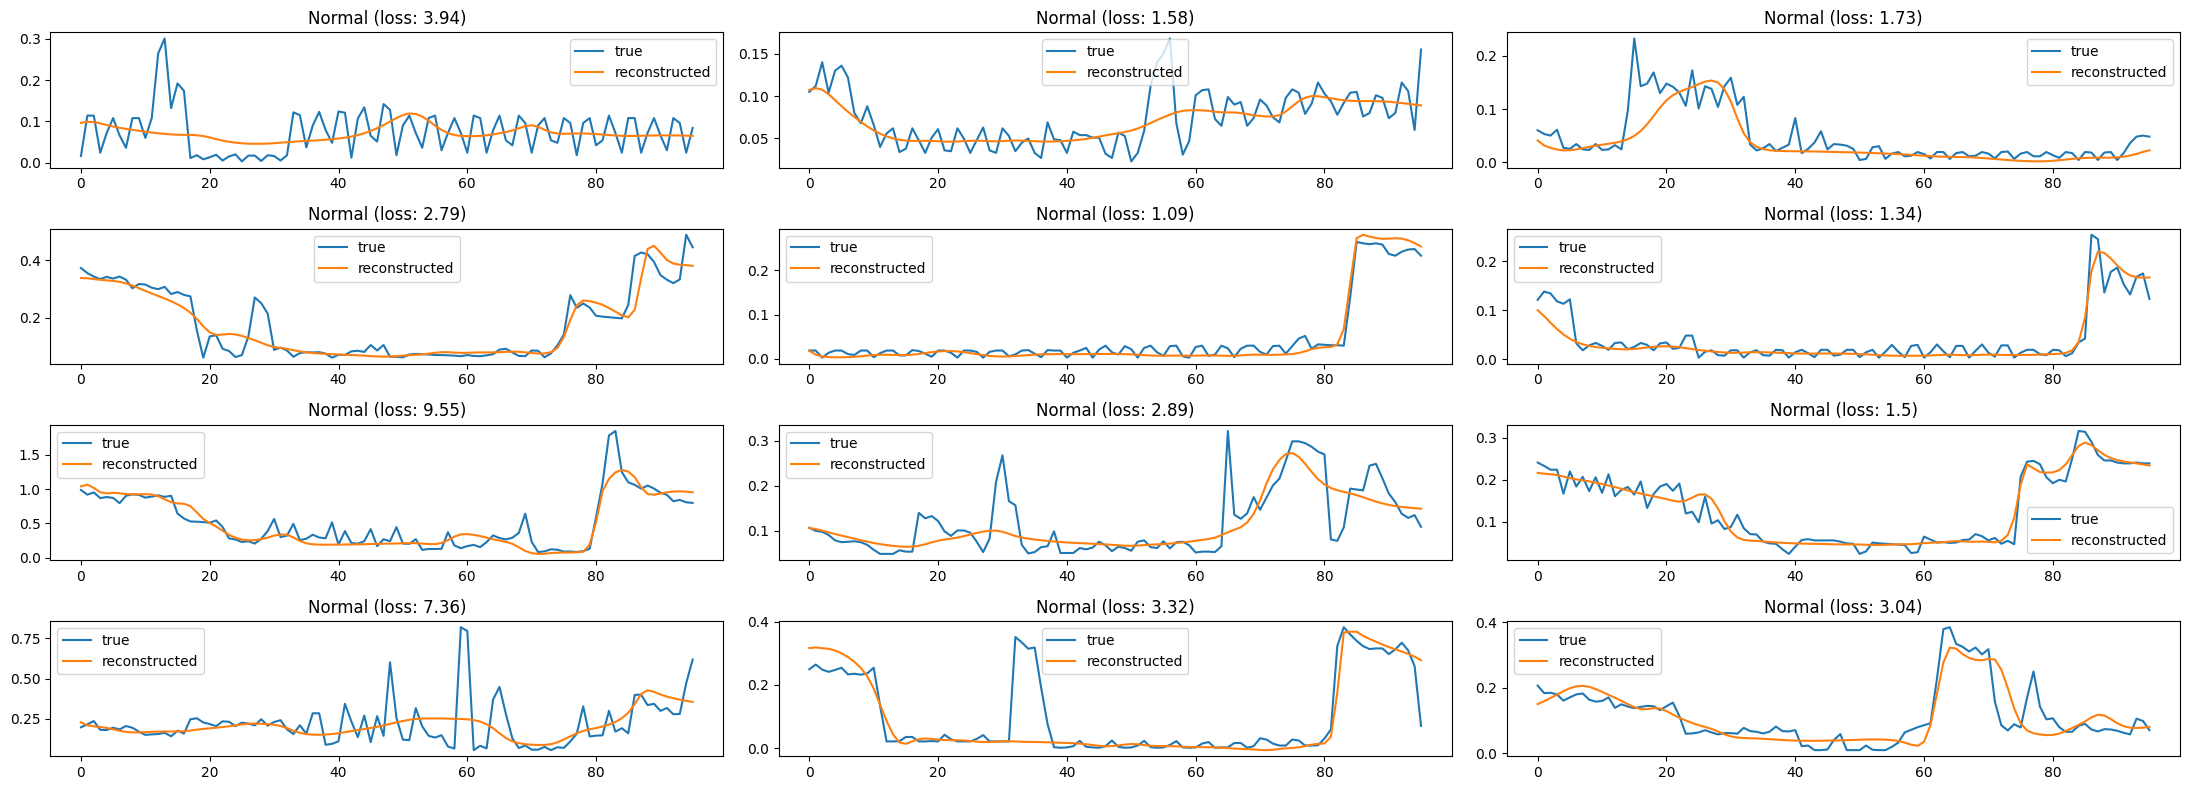

In [55]:
fig, axs = plt.subplots(
  nrows=4,
  ncols=3,
  # sharey=True,
  # sharex=True,
  figsize=(22, 8)
)

for i, data in enumerate(test_normal_dataset[20:23]):
    plot_prediction(data, model, title='Normal', ax=axs[0, i])
    
for i, data in enumerate(test_normal_dataset[23:26]):
    plot_prediction(data, model, title='Normal', ax=axs[1, i])
    
for i, data in enumerate(test_normal_dataset[26:29]):
    plot_prediction(data, model, title='Normal', ax=axs[2, i])
    
for i, data in enumerate(test_normal_dataset[29:32]):
    plot_prediction(data, model, title='Normal', ax=axs[3, i])

plt.tight_layout()

[]

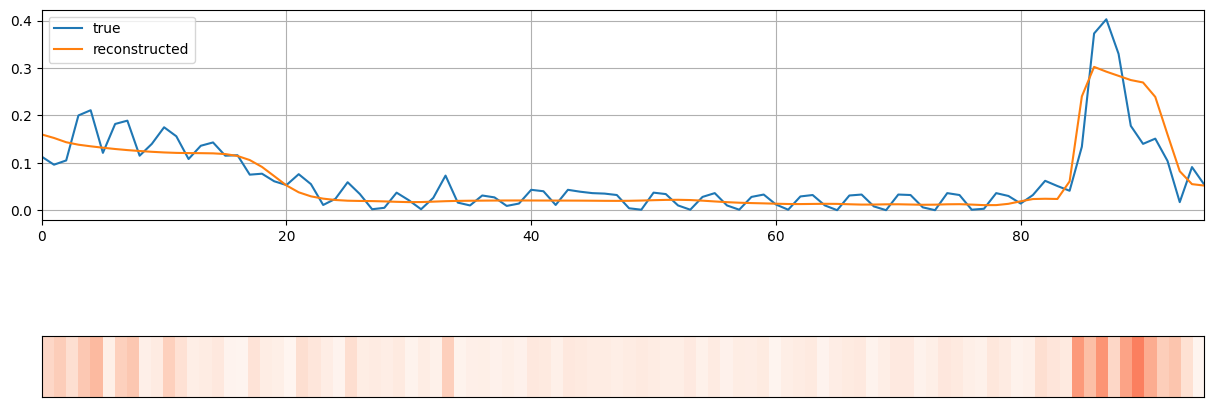

In [56]:
from sklearn.metrics import mean_absolute_error
from matplotlib.colors import LinearSegmentedColormap

fig, ax = plt.subplots(
  nrows=2,
  ncols=1,
  # sharey=True,
  # sharex=True,
  figsize=(15, 6)
)

predictions, pred_losses = predict(model, [test_normal_dataset[1]])

mse = np.abs(test_normal_dataset[1].T[0] - predictions[0])

ax[0].plot(test_normal_dataset[1], label='true')
ax[0].plot(predictions[0], label='reconstructed')
ax[0].grid(True)
ax[0].legend()
ax[0].set_xlim(0, len(test_normal_dataset[1])-1)

cmap = LinearSegmentedColormap.from_list('RedGreenRed', ['lime', 'crimson'])
# ax[1].imshow(np.atleast_2d(mse), aspect=5, cmap='Wistia', vmin=0, vmax=0.1)
ax[1].imshow(np.atleast_2d(mse), aspect=5, cmap='Reds', vmin=0, vmax=0.3)
ax[1].set_xticks([])
ax[1].set_yticks([])

# plt.tight_layout();

## Generate Attack Type

In [131]:
# Generate artificial samples for attack type 1: Consumption profile modification
def generate_attack_type_1(data):
    data_copy = data.copy()
    alpha = np.random.uniform(0.1, 0.8)
    return data_copy * alpha

# Generate artificial samples for attack type 2: Meter data modification
def generate_attack_type_2(data):
    data_copy = data.copy()
    gamma = np.random.uniform(0.2, 0.8, size=data_copy.shape)
    return data_copy * gamma


# Generate artificial samples for attack type 3: Meter tampering detection evasion
def generate_attack_type_3(data):
    start_time = np.random.randint(0, 96 - 6)
    duration = np.random.randint(6, 96)
    end_time = start_time + duration
    attack = data.copy()
    attack[start_time:end_time] = 0
    return attack

# Generate artificial samples for attack type 4: Magnetic field detection evasion
def generate_attack_type_4(data):
    data_copy = data.copy()
    mean_value = np.mean(data_copy)
    mean_value = np.full(data_copy.shape[0], mean_value)
    gamma = np.random.uniform(0.2, 0.8, size=data_copy.shape)
    return gamma * mean_value

# Generate artificial samples for attack type 5: Jamming attack
def generate_attack_type_5(data):
    data_copy = data.copy()
    mean_value = np.mean(data_copy)
    return np.full(data_copy.shape[0], mean_value)

# Generate artificial samples for attack type 6: False data injection
def generate_attack_type_6(data):
    data_copy = data.copy()
    inverted_data = data_copy[::-1]
    return inverted_data

In [78]:
# Seleted user
user_6 = clean_data(df, 6)
user_6

KWH
DATE-Time                 
2021-01-01 00:00:00  0.154
2021-01-01 00:15:00  0.143
2021-01-01 00:30:00  0.157
2021-01-01 00:45:00  0.128
2021-01-01 01:00:00  0.115
...                    ...
2021-08-31 22:45:00  0.325
2021-08-31 23:00:00  0.279
2021-08-31 23:15:00  0.292
2021-08-31 23:30:00  0.236
2021-08-31 23:45:00  0.227

[22944 rows x 1 columns]

In [79]:
# Example usage
window_size = 96
user_6 = user_6.to_numpy()
windowed_data_user_6 = create_windowed_dataset(user_6, window_size)
print(f" Window shape : {windowed_data_user_6.shape}")
print(f" Type of Window : {type(windowed_data_user_6)}")

 Window shape : (239, 96)
 Type of Window : <class 'numpy.ndarray'>


In [92]:
user_6_normal_dataset, _, _ = create_dataset(windowed_data_user_6)   # We got list of tensor

1. torch.Tensor().numpy()
2. torch.Tensor().cpu().data.numpy()
3. torch.Tensor().cpu().detach().numpy()

In [108]:
# Convert each tensor to numpy array and append to a new list
numpy_list = []
for tensor in user_6_normal_dataset:
    numpy_list.append(tensor.numpy())

# Convert list of numpy arrays to a 3D numpy array
user_6_normal_dataset = np.array(numpy_list)

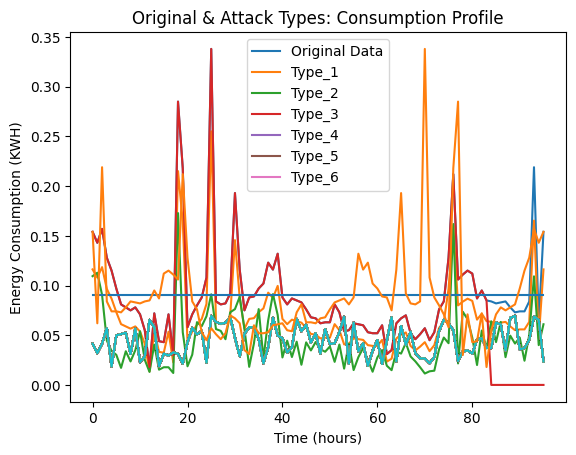

In [136]:
day = 0
windowed_data_test = user_6_normal_dataset.copy()
attack_type_1 = generate_attack_type_1(windowed_data_test[day])
attack_type_2 = generate_attack_type_2(windowed_data_test[day])
attack_type_3 = generate_attack_type_3(windowed_data_test[day])
attack_type_4 = generate_attack_type_4(windowed_data_test[day])
attack_type_5 = generate_attack_type_5(windowed_data_test[day])
attack_type_6 = generate_attack_type_6(windowed_data_test[day])
# Plot the original data and the modified data
plt.plot(user_6_normal_dataset[day])
plt.plot(attack_type_1)
plt.plot(attack_type_2)
plt.plot(attack_type_3)
plt.plot(attack_type_4)
plt.plot(attack_type_5)
plt.plot(attack_type_6)
plt.title("Original & Attack Types: Consumption Profile")
plt.xlabel("Time (hours)")
plt.ylabel("Energy Consumption (KWH)")
plt.legend(["Original Data", "Type_1", "Type_2", "Type_3", "Type_4", "Type_5", "Type_6"])
plt.show()

### Choosing a threshold

With our model at hand, we can have a look at the reconstruction error on the training set. Let's start by writing a helper function to get predictions from our model:

In [137]:
def predict(model, dataset):
    predictions, losses = [], []
    criterion = nn.L1Loss(reduction='sum').to(device)
    with torch.no_grad():
        model = model.eval()
        for seq_true in dataset:
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)

            loss = criterion(seq_pred, seq_true)

            predictions.append(seq_pred.cpu().numpy().flatten())
            losses.append(loss.item())
    return predictions, losses

Our function goes through each example in the dataset and records the predictions and losses. Let's get the losses and have a look at them:

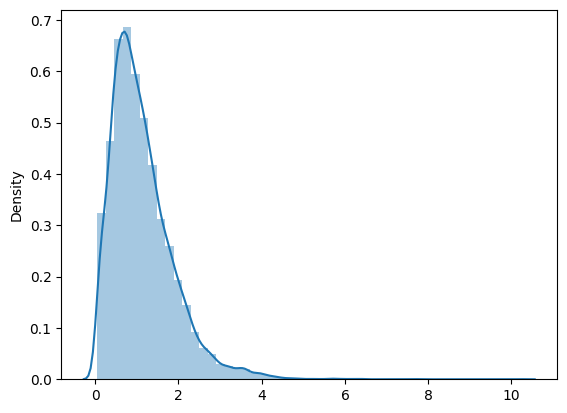

In [138]:
_, losses = predict(model, train_dataset)

sns.distplot(losses, bins=50, kde=True);

In [139]:
THRESHOLD = 4

### Evaluation

Using the threshold, we can turn the problem into a simple binary classification task:

* If the reconstruction loss for an example is below the threshold, we'll classify it as a normal heartbeat
* Alternatively, if the loss is higher than the threshold, we'll classify it as an anomaly

### Normal energy consumption

Let's check how well our model does on normal datasets. We'll use the normal datasets from the test set (our model haven't seen those):

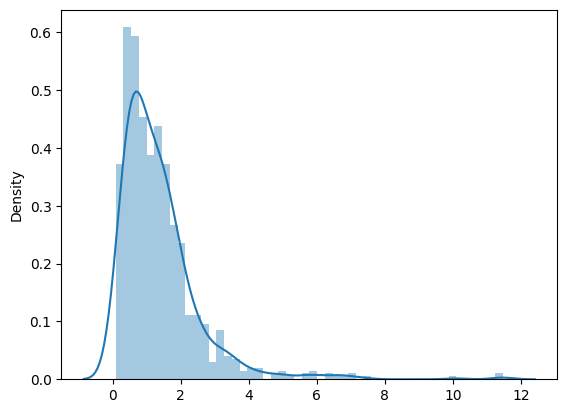

In [140]:
predictions, pred_losses = predict(model, test_normal_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

We'll count the correct predictions:

In [141]:
correct = sum(l <= THRESHOLD for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

Correct normal predictions: 847/874


### Anomalies

We'll do the same with the anomaly examples, but their number is much higher. We'll get a subset that has the same size as the normal datasets:

We can add this type of theif attacks

In [151]:
type(test_normal_dataset[0])

torch.Tensor

In [181]:
attack_type_3 = generate_attack_type_3(windowed_data_test[day])  #It has the shape (96, 1)

In [182]:
attack_type_3 = create_windowed_dataset(attack_type_3, 96)     #Reshape, it should has shape (1, 96)

In [183]:
attack_type_3, _, _ = create_dataset(attack_type_3)            #List of Tensor

In [206]:
day = 0
windowed_data_test = user_6_normal_dataset.copy()

In [209]:
windowed_data_test = create_windowed_dataset(windowed_data_test[day], 96)
windowed_data_test, _, _ = create_dataset(windowed_data_test)

In [184]:
# anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]

Now we can take the predictions of our model for the subset of anomalies:

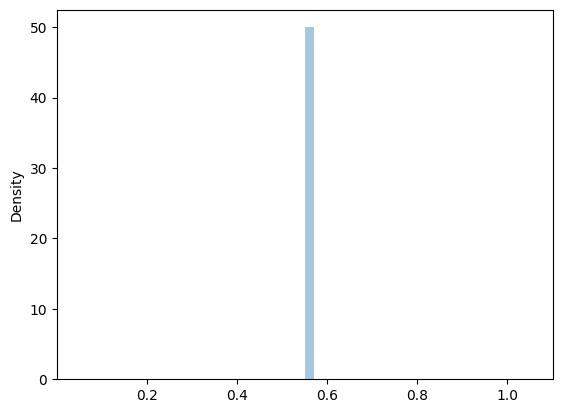

In [185]:
predictions, pred_losses = predict(model, attack_type_3)
sns.distplot(pred_losses, bins=50, kde=True);

Finally, we can count the number of examples above the threshold (considered as anomalies):

We have very good results. In the real world, you can tweak the threshold depending on what kind of errors you want to tolerate. In this case, you might want to have more false positives (normal heartbeats considered as anomalies) than false negatives (anomalies considered as normal).

### Looking at Examples

We can overlay the real and reconstructed Time Series values to see how close they are. We'll do it for some normal and anomaly cases:

In [68]:
predictions, pred_losses = predict(model, [test_normal_dataset[21]])

In [69]:
print(len(test_normal_dataset[21]))

96


In [83]:
mse = np.abs(test_normal_dataset[21] - predictions[0])
mse.shape

torch.Size([96, 96])

In [100]:
test_normal_dataset[21].T[0].shape

torch.Size([96])

In [101]:
mse = np.abs(test_normal_dataset[21].T[0] - predictions[0])
mse.shape

torch.Size([96])

In [162]:
def reconstructed_probability(self, x: torch.Tensor) -> torch.Tensor:
        """
        Computes the probability density of the input samples under the learned
        distribution of reconstructed data.
        Args:
            x: Input data tensor of shape (batch_size, num_features).
        Returns:
            A tensor of shape (batch_size,) containing the probability densities of
            the input samples under the learned distribution of reconstructed data.
        """
        with torch.no_grad():
            pred = self.predict(x)
        recon_dist = Normal(pred['recon_mu'], pred['recon_sigma'])
        x = x.unsqueeze(0)
        p = recon_dist.log_prob(x).exp().mean(dim=0).mean(dim=-1)  # vector of shape [batch_size]
        return p

In [159]:
from scipy.stats import norm
# Fit a normal distribution to the data:
mu, std = norm.fit(test_normal_dataset[21].T[0])

In [161]:
print(mu)
print(std)

0.15803124
0.08255976


https://github.com/hupili/python-for-data-and-media-communication-gitbook/issues/118

### Probability Reconstruction Loss
https://github.com/Michedev/VAE_anomaly_detection/blob/master/model/VAE.py

[]

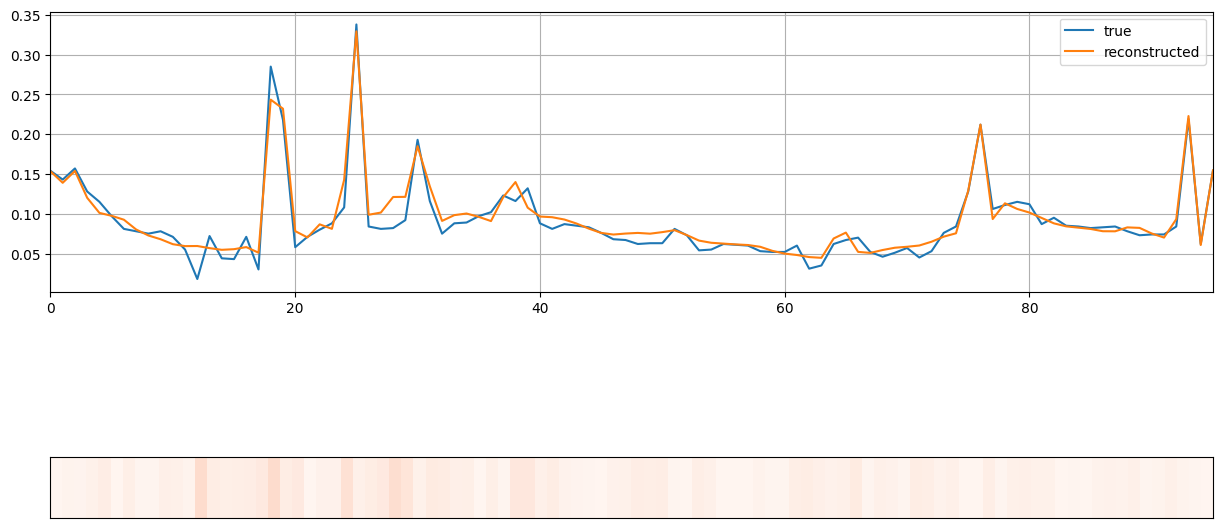

In [211]:
from sklearn.metrics import mean_absolute_error
from matplotlib.colors import LinearSegmentedColormap

fig, ax = plt.subplots(
  nrows=2,
  ncols=1,
  # sharey=True,
  # sharex=True,
  figsize=(15, 8)
)

predictions, pred_losses = predict(model, [windowed_data_test[0]])

mse = np.abs(windowed_data_test[0].T[0] - predictions[0])

ax[0].plot(windowed_data_test[0], label='true')
ax[0].plot(predictions[0], label='reconstructed')
ax[0].grid(True)
ax[0].legend()
ax[0].set_xlim(0, len(windowed_data_test[0])-1)

cmap = LinearSegmentedColormap.from_list('RedGreenRed', ['lime', 'crimson'])
# ax[1].imshow(np.atleast_2d(mse), aspect=5, cmap='Wistia', vmin=0, vmax=0.1)
ax[1].imshow(np.atleast_2d(mse), aspect=5, cmap='Reds', vmin=0, vmax=0.3)
ax[1].set_xticks([])
ax[1].set_yticks([])

# plt.tight_layout();

[]

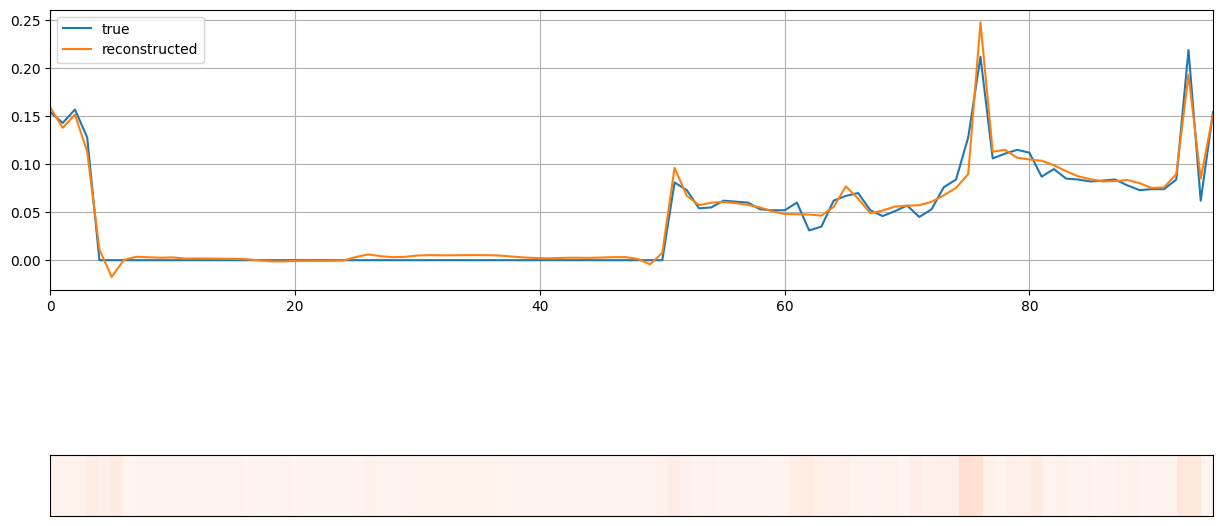

In [212]:
from sklearn.metrics import mean_absolute_error
from matplotlib.colors import LinearSegmentedColormap

fig, ax = plt.subplots(
  nrows=2,
  ncols=1,
  # sharey=True,
  # sharex=True,
  figsize=(15, 8)
)

predictions, pred_losses = predict(model, [attack_type_3[0]])

mse = np.abs(attack_type_3[0].T[0] - predictions[0])

ax[0].plot(attack_type_3[0], label='true')
ax[0].plot(predictions[0], label='reconstructed')
ax[0].grid(True)
ax[0].legend()
ax[0].set_xlim(0, len(attack_type_3[0])-1)

cmap = LinearSegmentedColormap.from_list('RedGreenRed', ['lime', 'crimson'])
# ax[1].imshow(np.atleast_2d(mse), aspect=5, cmap='Wistia', vmin=0, vmax=0.1)
ax[1].imshow(np.atleast_2d(mse), aspect=5, cmap='Reds', vmin=0, vmax=0.3)
ax[1].set_xticks([])
ax[1].set_yticks([])

# plt.tight_layout();

In [177]:
attack_type_1[0][:5]

tensor([[0.0363],
        [0.0337],
        [0.0370],
        [0.0302],
        [0.0271]])

In [179]:
test_normal_dataset[21][:5]

tensor([[0.1570],
        [0.0900],
        [0.0880],
        [0.1270],
        [0.1230]])

[]

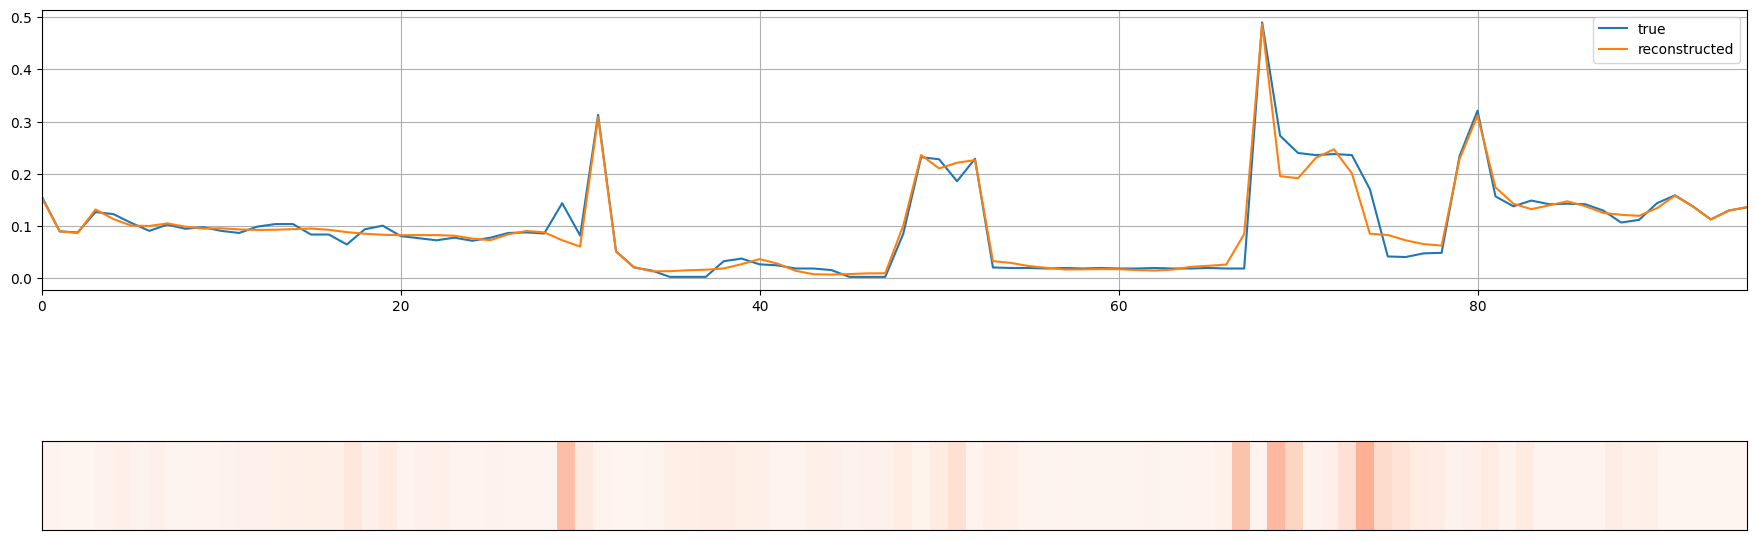

In [173]:
from sklearn.metrics import mean_absolute_error
from matplotlib.colors import LinearSegmentedColormap

fig, ax = plt.subplots(
  nrows=2,
  ncols=1,
  # sharey=True,
  # sharex=True,
  figsize=(22, 8)
)

predictions, pred_losses = predict(model, [test_normal_dataset[21]])

mse = np.abs(test_normal_dataset[21].T[0] - predictions[0])

ax[0].plot(test_normal_dataset[21], label='true')
ax[0].plot(predictions[0], label='reconstructed')
ax[0].grid(True)
ax[0].legend()
ax[0].set_xlim(0, len(test_normal_dataset[21])-1)

cmap = LinearSegmentedColormap.from_list('RedGreenRed', ['lime', 'crimson'])
# ax[1].imshow(np.atleast_2d(mse), aspect=5, cmap='Wistia', vmin=0, vmax=0.1)
ax[1].imshow(np.atleast_2d(mse), aspect=5, cmap='Reds', vmin=0, vmax=0.3)
ax[1].set_xticks([])
ax[1].set_yticks([])

# plt.tight_layout();

In [56]:
# [test_normal_dataset[0]]

In [71]:
def plot_prediction(data, model, title, ax):
    predictions, pred_losses = predict(model, [data])

    ax.plot(data, label='true')
    ax.plot(predictions[0], label='reconstructed')
    ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
    
    # ax[1].imshow(np.atleast_2d(pred_losses), aspect=5, cmap='Wistia')
    # ax[1].set_xticks([])
    # ax[1].set_yticks([])
    
    ax.legend()

In [45]:
# def plot_prediction(data, model, title, ax):
#     predictions, pred_losses = predict(model, [data])
#     pos = int(len(data)-1)
#     se = np.square(data - predictions[0])
#     se = se[:, pos]

#     ax.plot(data, label='true')
#     ax.plot(predictions[0], label='reconstructed')
#     ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')

#     ax.imshow(np.atleast_3d(se).T, aspect=5, cmap='Wistia')
#     ax.set_xticks([])
#     ax.set_yticks([])
#     ax.legend()

In [46]:
# from matplotlib.colors import LinearSegmentedColormap
# def plot_prediction(data, model, title, ax):
#     predictions, pred_losses = predict(model, [data])
#     pos = int(len(data)-1)
#     se = np.square(data - predictions[0])
#     se = se[:, pos]

#     ax1 = ax[0]
#     ax1.plot(data, label='true')
#     ax1.plot(predictions[0], label='reconstructed')
#     ax1.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
#     ax1.legend()
#     ax1.set_xlim(0, len(data))
    
#     # rdgn = sns.diverging_palette(h_neg=130, h_pos=10, s=99, l=55, sep=3, as_cmap=True)
#     ax2 = ax[1]
#     im = ax2.imshow(np.atleast_3d(se).T, aspect=5, cmap='Wistia')
#     ax2.set_xticks([])
#     ax2.set_yticks([])
#     # fig.colorbar(im, ax=ax2)
#     return ax1, ax2

In [47]:
# fig, axs = plt.subplots(2, 1, figsize=(8, 6))
# plot_prediction(data, model, title='Prediction', ax=axs)
# plt.tight_layout()
# plt.show()

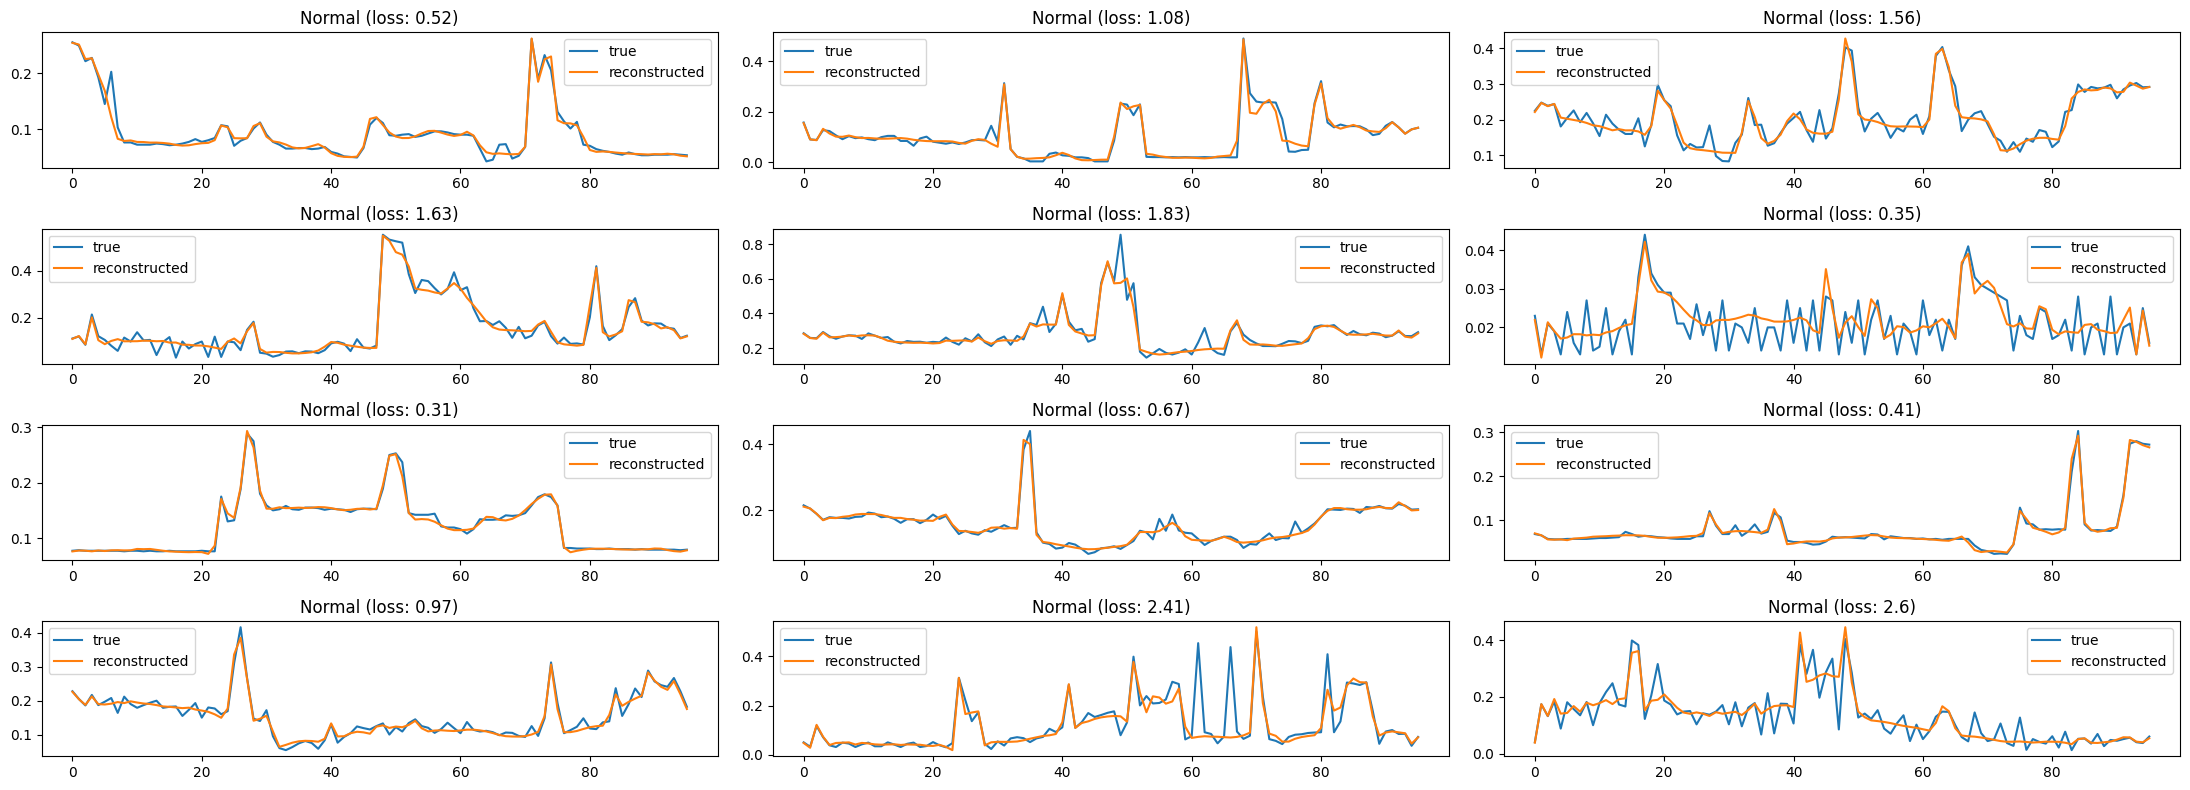

In [72]:
fig, axs = plt.subplots(
  nrows=4,
  ncols=3,
  # sharey=True,
  # sharex=True,
  figsize=(22, 8)
)

for i, data in enumerate(test_normal_dataset[20:23]):
    plot_prediction(data, model, title='Normal', ax=axs[0, i])
    
for i, data in enumerate(test_normal_dataset[23:26]):
    plot_prediction(data, model, title='Normal', ax=axs[1, i])
    
for i, data in enumerate(test_normal_dataset[26:29]):
    plot_prediction(data, model, title='Normal', ax=axs[2, i])
    
for i, data in enumerate(test_normal_dataset[29:32]):
    plot_prediction(data, model, title='Normal', ax=axs[3, i])

plt.tight_layout()

### Test

In [195]:
df_test

MeterID            DATE-Time  KWH  user user_1
11025816  6200028570  2021-01-01 00:00:00  0.0   510      0
11025817  6200028570  2021-01-01 00:15:00  0.0   510      0
11025818  6200028570  2021-01-01 00:30:00  0.0   510      0
11025819  6200028570  2021-01-01 00:45:00  0.0   510      0
11025820  6200028570  2021-01-01 01:00:00  0.0   510      0
...              ...                  ...  ...   ...    ...
11045667  6200028570  2021-07-31 22:45:00  0.0   510      0
11045668  6200028570  2021-07-31 23:00:00  0.0   510      0
11045669  6200028570  2021-07-31 23:15:00  0.0   510      0
11045670  6200028570  2021-07-31 23:30:00  0.0   510      0
11045671  6200028570  2021-07-31 23:45:00  0.0   510      0

[19856 rows x 5 columns]

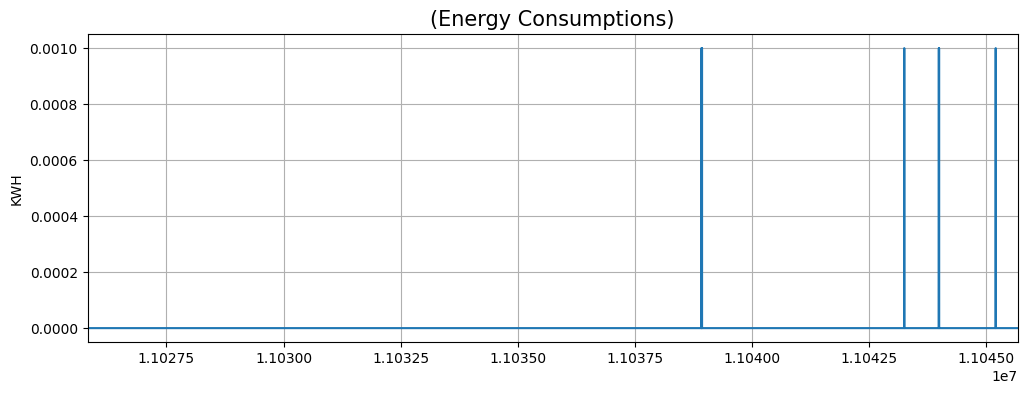

In [196]:
plt.figure(figsize=(12,4))
plt.title('(Energy Consumptions)', size=15)
plt.ylabel('KWH')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df_test['KWH'])
plt.show()

## 5. Evaluate the model using the test set

# Task

### VAE autocoder
* https://www.google.com/search?q=variational+autoencoder+based+anomaly+detection+using+reconstruction+probability+github&rlz=1C5CHFA_enTH999TH999&oq=Variational+Autoencoder+based+Anomaly+Detection+using+Reconstruction+Probability+&aqs=chrome.1.69i57j0i512j69i60.3070j0j7&sourceid=chrome&ie=UTF-8
* https://github.com/Michedev/VAE_anomaly_detection
* https://github.com/smile-yan/vae-anomaly-detection
* https://github.com/tarekmuallim/Anomaly-Detection-using-Variational-Autoencoders/blob/master/anomaly_detection_using_vae.py


### CNN
* https://github.com/khanmhmdi/Cifar-Image-Reconstruction-using-Autoencoder-Models/blob/main/Image_reconstruction.ipynb
* https://github.com/ebrahimpichka/conv-autoencoder (test on this now!!)